### Modulos necesarios proyecto final

In [3]:
# Imports
import sys
import os

import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from kneed import KneeLocator
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
import time
import logging
import joblib

### Path de los archivos del proyecto

In [4]:
src_spotify_dataset = './Source/tracks.csv'
src_spotify_new_dataset = './Source/cancionesSpotify.csv'

data_scaled_pkl = './Data/data_scaled.pkl'
data_scaled_labeled_pkl = './Data/data_scaled_labeled.pkl'
data_train_pkl = './Data/data_train.pkl'
data_test_pkl = './Data/data_test.pkl'
data_new_scaled_pkl = './Data/data_new_scaled.pkl'
data_new_scaled_labeled_pkl = './Data/data_new_scaled_labeled.pkl'

model_kmeans_pkl = './Models/model_kmeans.pkl'
model_random_forest_pkl = './Models/model_random_forest.pkl'
model_grid_random_forest_pkl = './Models/model_grid_random_forest.pkl'
model_knn_pkl = './Models/model_knn.pkl'
model_grid_knn_pkl = './Models/model_grid_knn.pkl'
model_logistic_regression_pkl = './Models/model_logistic_regression.pkl'
model_grid_logistic_regression_pkl = './Models/model_grid_logistic_regression.pkl'
model_svc_pkl = './Models/model_svc.pkl'
model_grid_svc_pkl = './Models/model_grid_svc.pkl'
model_hist_gradient_boost_pkl = './Models/model_hist_gradient_boost.pkl'
model_grid_hist_gradient_boost_pkl = './Models/model_grid_hist_gradient_boost.pkl'
model_xgboost_pkl = './Models/model_xgboost.pkl'
model_grid_xgboost_pkl = './Models/model_grid_xgboost.pkl'

### Normalizacion de datos

> **_NOTE:_** Explicar la normalizacion maunal y los valores rango de tempo y loudness !!!

### 1. Rationale Behind Initial Feature Selection

Spotify provides several audio features, including:

- `danceability`, `energy`, `loudness`, `speechiness`, `acousticness`, `instrumentalness`, `liveness`, `valence`, `tempo`, `mode`, and `key`.

To accurately model a song's emotional mood based on the **Circumplex Model of Emotion** by James Russell—which characterizes emotions using two primary dimensions: **Valence (pleasantness)** and **Arousal (energy level)**—it's essential to select features closely correlated with these dimensions.

Thus, the initial feature selection targeted attributes directly related to emotional perception and energy levels experienced in music.

---

### 2. Exclusion of Less Relevant Features

The following features were excluded due to their weaker or indirect correlation with emotional dimensions:

- **Speechiness**: Indicates spoken words rather than musical emotion.
- **Acousticness**: Differentiates acoustic from electronic tracks but does not consistently reflect valence or arousal.
- **Instrumentalness**: Distinguishes instrumental from vocal music; important stylistically but weakly linked to emotional intensity.
- **Liveness**: Captures live audience presence but doesn't significantly affect emotional mood.
- **Mode** (major/minor scale): Traditionally associated with mood but limited in capturing consistent emotional intensity or energy.
- **Key**: Primarily related to musical composition, with limited direct emotional correlation.

---

### 3. Selection of Relevant Emotional Features

The final selected features were:

- `valence`, `energy`, `tempo`, `loudness`, `danceability`

These were chosen for their direct, empirically supported relationship with emotional perception:

- **Valence**: Measures musical positivity (happiness, cheerfulness) versus negativity (sadness, melancholy), directly aligning with Russell's "pleasantness" dimension.
- **Energy**: Captures perceived intensity and activity level, strongly correlated with emotional arousal.
- **Tempo**: The speed of the music, significantly influencing perceived arousal—faster tempos generally increase arousal.
- **Loudness**: Reflects volume, influencing perceived intensity and energy (louder music is typically perceived as more energetic).
- **Danceability**: Indicates suitability for dancing, indirectly measuring rhythmic engagement and bodily activation, related to arousal.

---

### 4. Computation of the Final Feature: "Arousal"

Since Spotify explicitly measures "Valence," it remains unchanged. However, to create the "Arousal" dimension, the following weighted combination of relevant features (`energy`, `tempo`, `loudness`, and `danceability`) was calculated after normalization:

| Feature      | Weight | Reason for Weighting                                  |
|--------------|--------|--------------------------------------------------------|
| Energy       | 0.50   | Primary indicator of perceived intensity and energy.  |
| Tempo        | 0.25   | Strongly affects perceived activity and stimulation.  |
| Loudness     | 0.20   | Moderately influences perceived intensity.            |
| Danceability | 0.05   | Least influential; indirect rhythmic activation.      |

**Formula for Computing Arousal:**

```python
# Define feature weights
alpha = 0.50  # Energy (primary indicator)
beta = 0.25   # Tempo (important secondary factor)
gamma = 0.20  # Loudness (moderate influence)
delta = 0.05  # Danceability (minor influence)

# Calculate normalized arousal score
data_scaled['arousal'] = (
    (alpha * data_scaled['energy']) +
    (beta * data_scaled['tempo']) +
    (gamma * data_scaled['loudness']) +
    (delta * data_scaled['danceability'])
)
```

---

### 5. Final Feature Set

Ultimately, the analysis produced two meaningful emotional features aligned with Russell’s Circumplex Model:

- **Valence** (pleasantness dimension)
- **Arousal** (energy/activity dimension)

This concise yet robust representation effectively captures essential emotional characteristics, ensuring reliable and interpretable predictions of a song's mood.

In [24]:
# Process dataset
def clean_normalize_dataset(input_csv: str, scaled_output_pkl: str = None, scaled_aux_output_pkl: str = None):

    start_time = time.time()
    print(f"Clean and Normalize Dataset")

    # Features
    old_features = ['energy','tempo','loudness','danceability','valence']
    new_features = ['arousal','valence']

    # Load the data and clean it (drop missing values)
    df = pd.read_csv(input_csv)
    print(f"Shape Original: {df.shape}")
    print(f"Missing data before cleanup: {df[old_features].isnull().sum().sum()} entries.")
    df = df[old_features].dropna().copy()
    print(f"Original Data Description:\n{df.describe()}")
    print(f"First few rows of the scaled data:\n{df.head()}")

    # Initialize the data_scaled DataFrame
    data_scaled = df.copy()

    # Define scaling ranges for specific features
    scale_ranges = {
        'tempo': (20, 200),
        'loudness': (-60, 0),
        'energy': (0, 1),
        'danceability': (0, 1),
        'valence': (0, 1)
    }

    # Clip values and apply scaling
    for feature, (min_input, max_input) in scale_ranges.items():
        min_output = 0
        max_output = 1
        data_scaled[feature] = data_scaled[feature].clip(lower=min_input, upper=max_input)
        data_scaled[feature] = (data_scaled[feature] - min_input) / (max_input - min_input) * (max_output - min_output) + min_output

    # Round the values to 3 decimal places for the features
    data_scaled = data_scaled.round(3)

    # Log the description after scaling
    print(f"Scaled Data Description:\n{data_scaled.describe()}")

    # Define the weights for the features
    alpha = 0.5  # Energy has more influence on arousal
    beta = 0.25  # Tempo is still important, but less than energy
    gamma = 0.2  # Loudness is less important, but still relevant
    delta = 0.05  # Danceability plays the least role in arousal
    
    # Calculate the arousal score (weighted sum of selected features)
    data_scaled['arousal'] = (alpha * data_scaled['energy']) + \
                             (beta * data_scaled['tempo']) + \
                             (gamma * data_scaled['loudness']) + \
                             (delta * data_scaled['danceability'])
    
    # Round the values for arousal
    data_scaled = data_scaled.round(3)

    # If scaled_aux_output_pkl is not None or empty, save the scaled data
    if scaled_aux_output_pkl:
        joblib.dump(data_scaled, scaled_aux_output_pkl)
        print(f"Scaled aux data saved to: {scaled_aux_output_pkl}")

    # Log the description after calculating arousal
    print(f"Data with Arousal Score Description:\n{data_scaled.describe()}")
    print(f"First few rows of the scaled data:\n{data_scaled.head()}")

    # Select the relevant columns (valence and arousal)
    scaled_df = data_scaled[new_features].dropna().copy()
    print(f"Shape Save: {df.shape}")

    # If scaled_output_pkl is not None or empty, Save the cleaned and scaled data
    if scaled_output_pkl:
        scaled_df.to_pickle(scaled_output_pkl)
        print(f"Scaled data saved to: {scaled_output_pkl}")

    print(f"Clean and Normalize Dataset Completed in {time.time() - start_time:.2f} seconds")

clean_normalize_dataset(src_spotify_dataset, data_scaled_pkl, None)

Clean and Normalize Dataset
Shape Original: (586672, 20)
Missing data before cleanup: 0 entries.
Original Data Description:
              energy          tempo       loudness   danceability  \
count  586672.000000  586672.000000  586672.000000  586672.000000   
mean        0.542036     118.464857     -10.206067       0.563594   
std         0.251923      29.764108       5.089328       0.166103   
min         0.000000       0.000000     -60.000000       0.000000   
25%         0.343000      95.600000     -12.891000       0.453000   
50%         0.549000     117.384000      -9.243000       0.577000   
75%         0.748000     136.321000      -6.482000       0.686000   
max         1.000000     246.381000       5.376000       0.991000   

             valence  
count  586672.000000  
mean        0.552292  
std         0.257671  
min         0.000000  
25%         0.346000  
50%         0.564000  
75%         0.769000  
max         1.000000  
First few rows of the scaled data:
   energy   

### Intentar entender cual es el numero de clusters ideal

Running KMeans for k = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] Clusters

Running K-Means for k=2


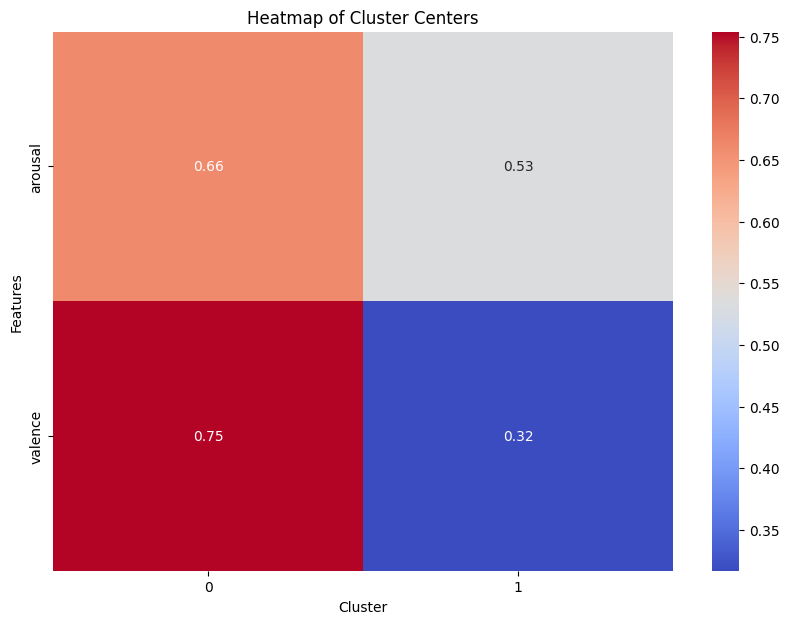

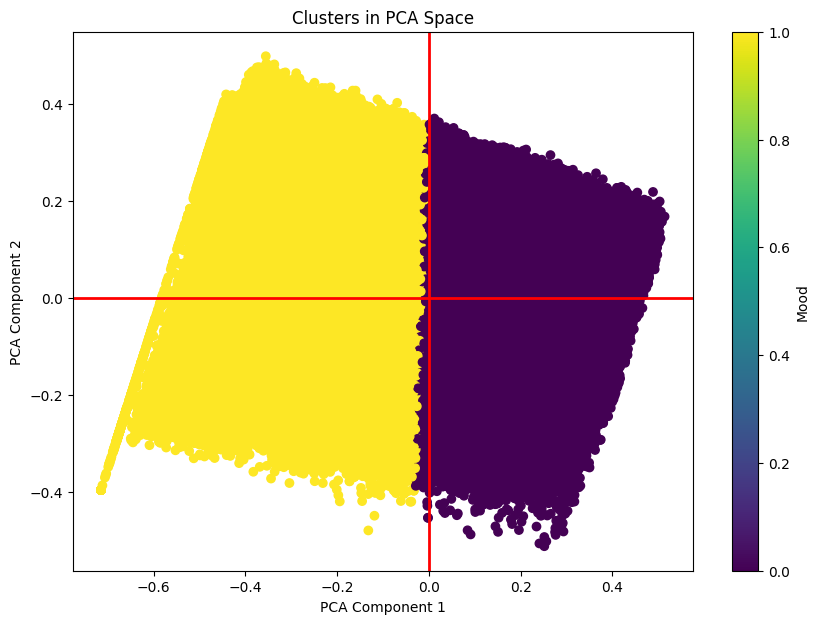

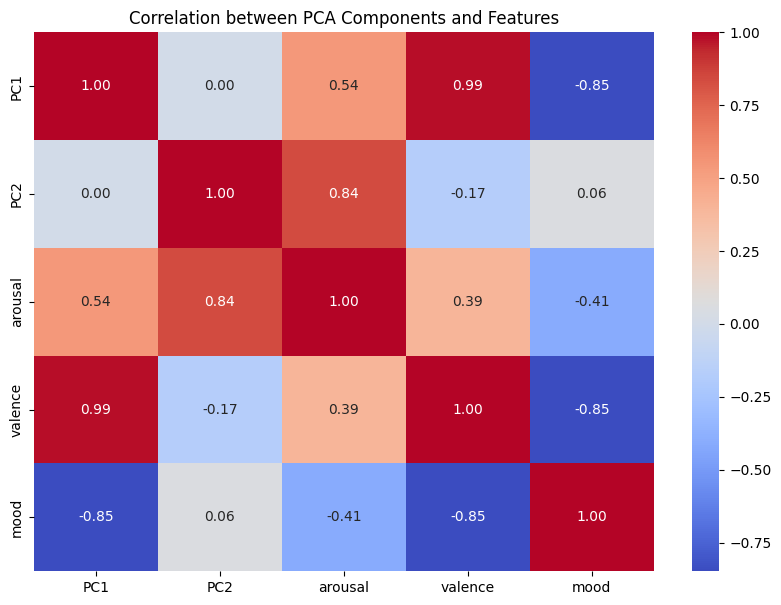

Completed K-Means for k=2 in 27.94 seconds


Running K-Means for k=3


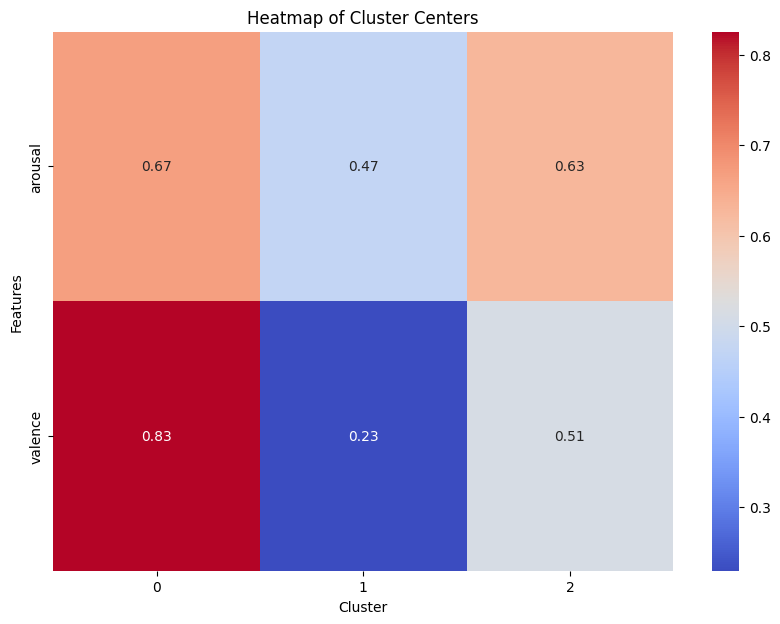

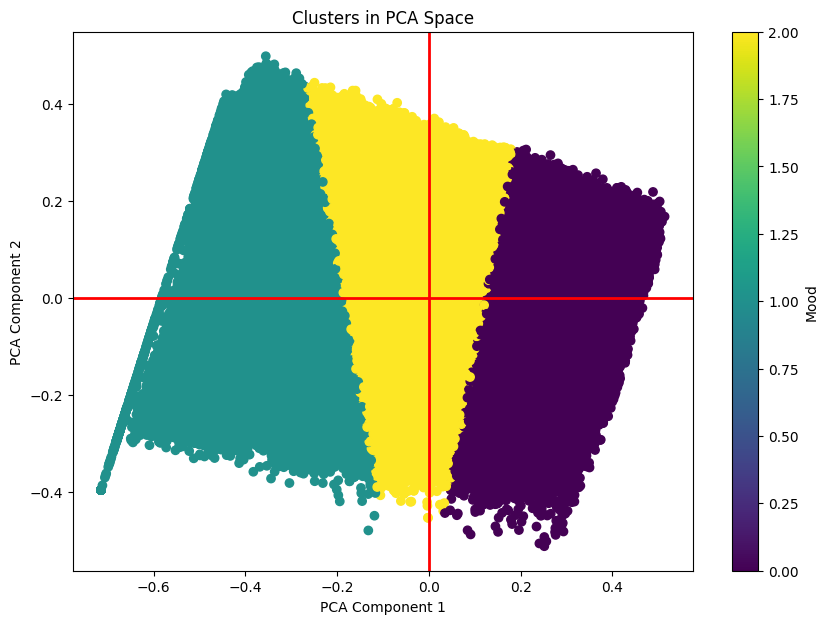

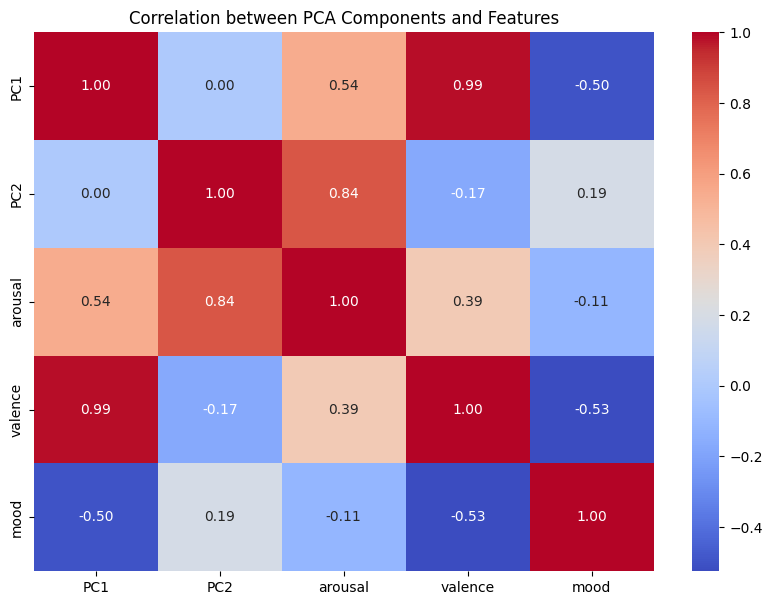

Completed K-Means for k=3 in 28.35 seconds


Running K-Means for k=4


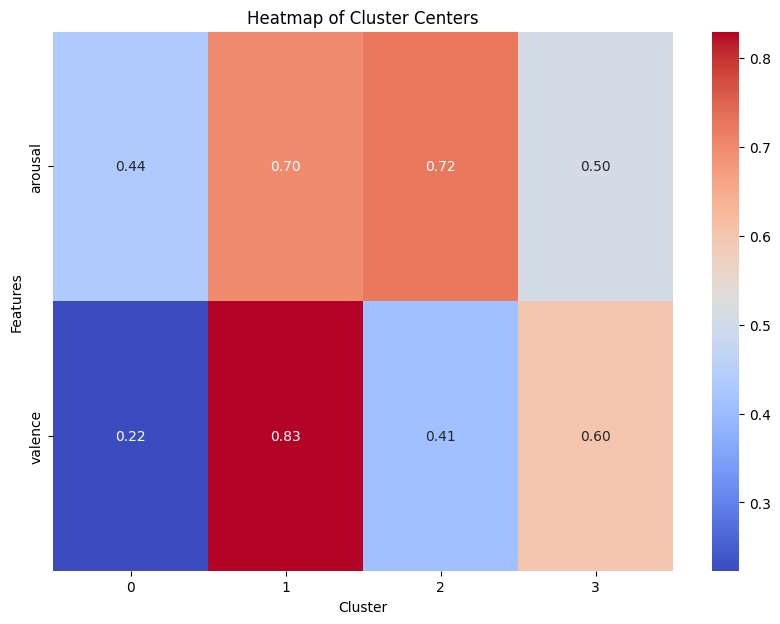

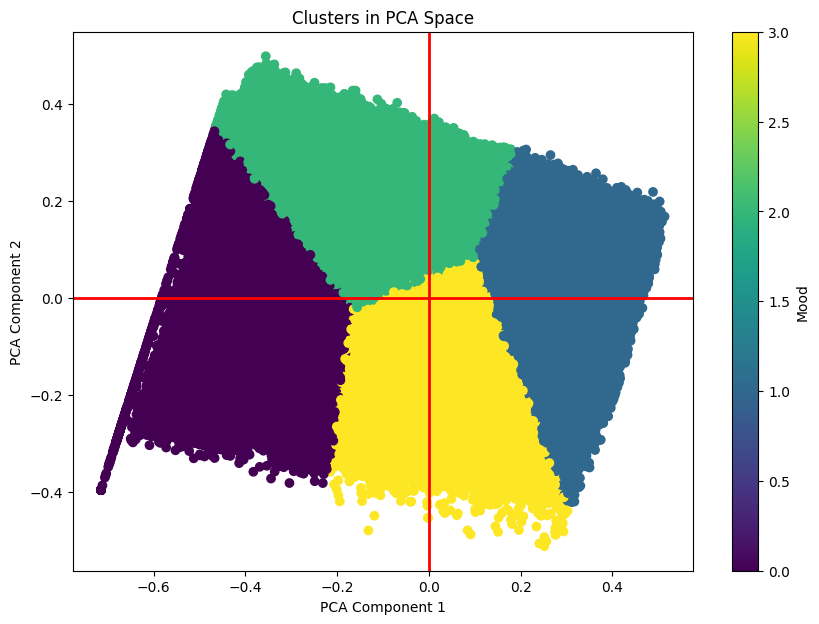

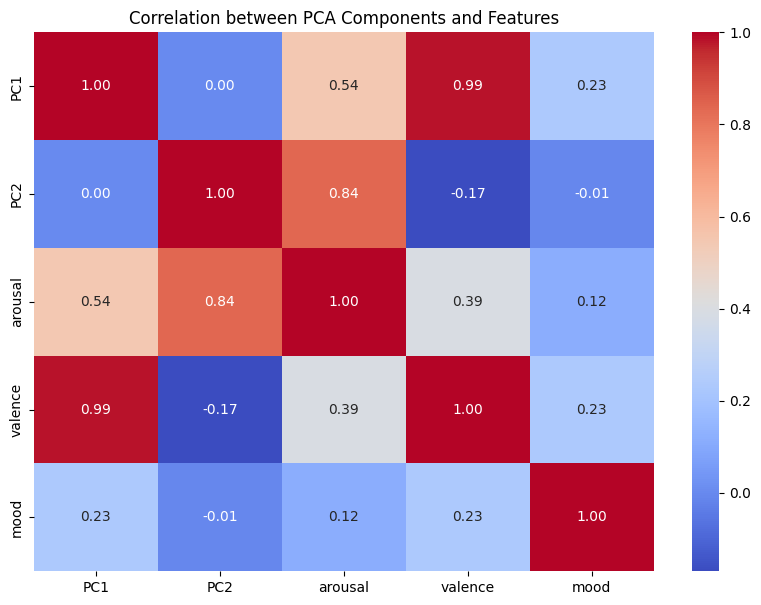

Completed K-Means for k=4 in 29.63 seconds


Running K-Means for k=5


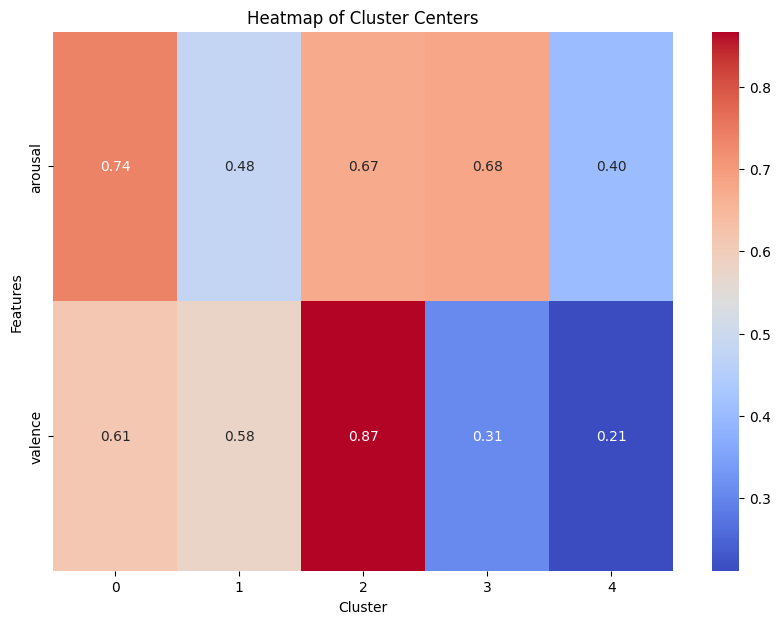

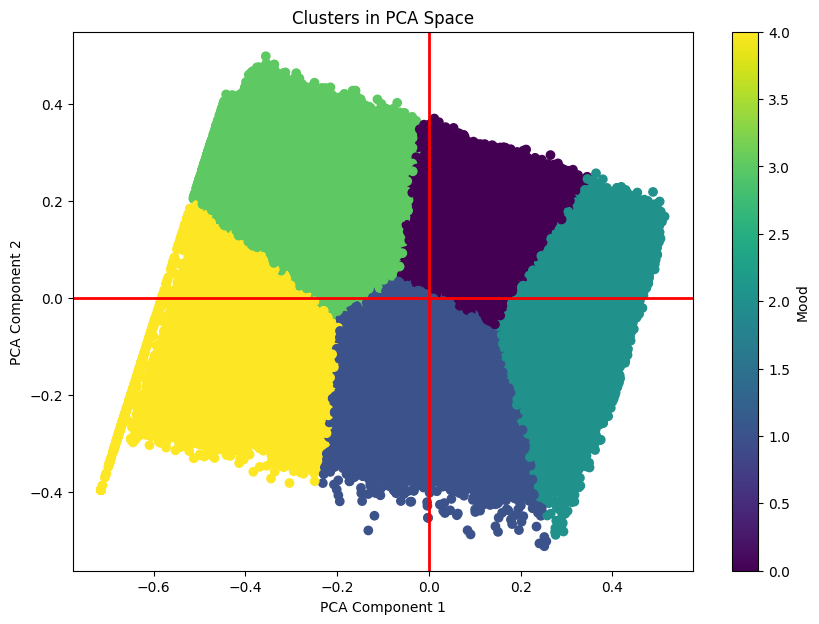

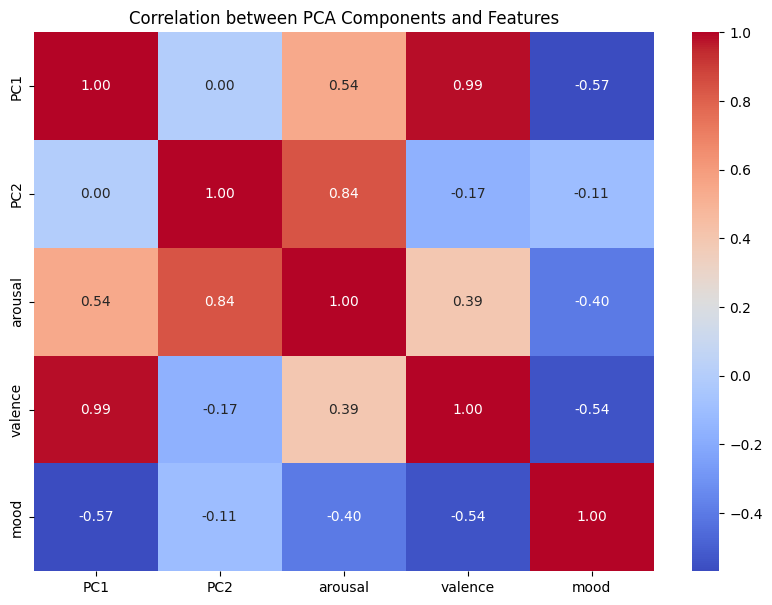

Completed K-Means for k=5 in 29.09 seconds


Running K-Means for k=6


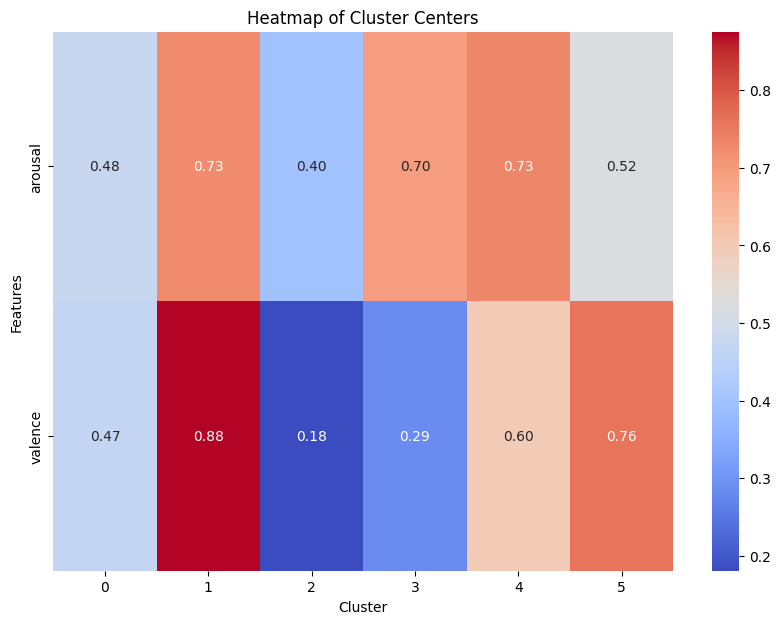

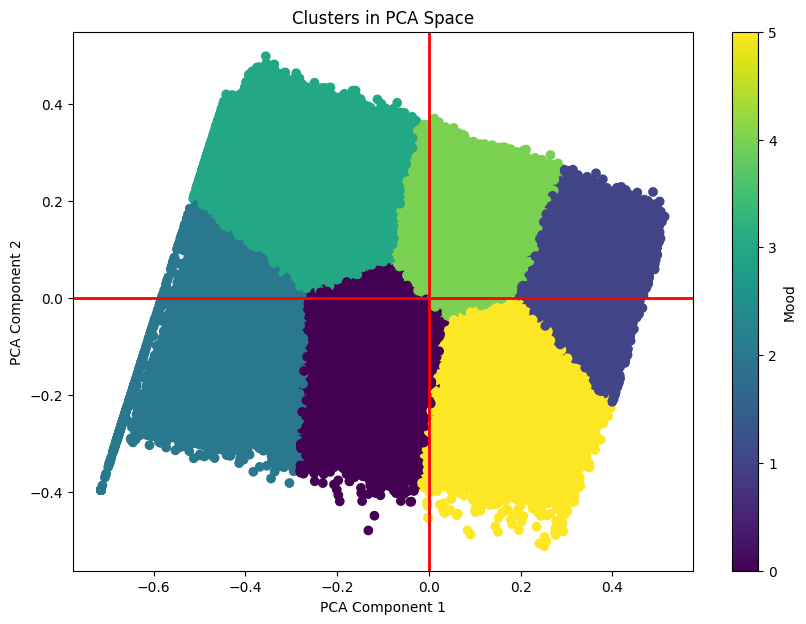

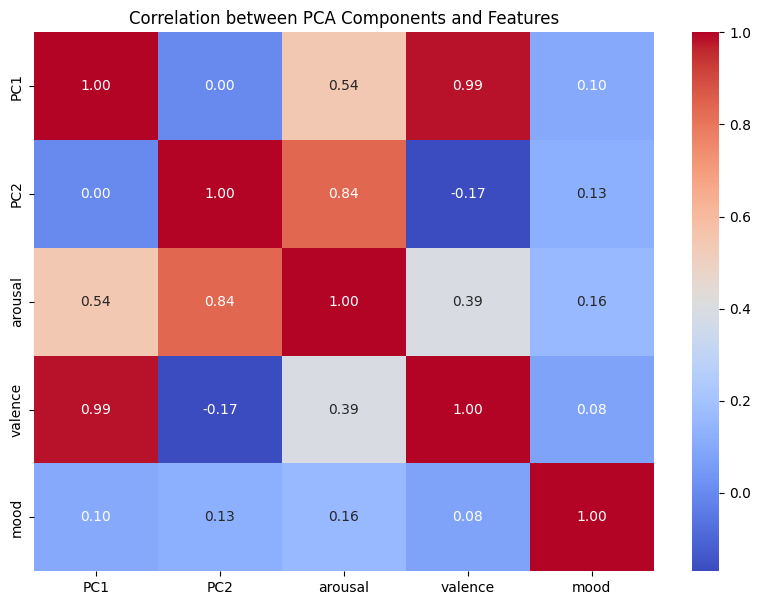

Completed K-Means for k=6 in 29.14 seconds


Running K-Means for k=7


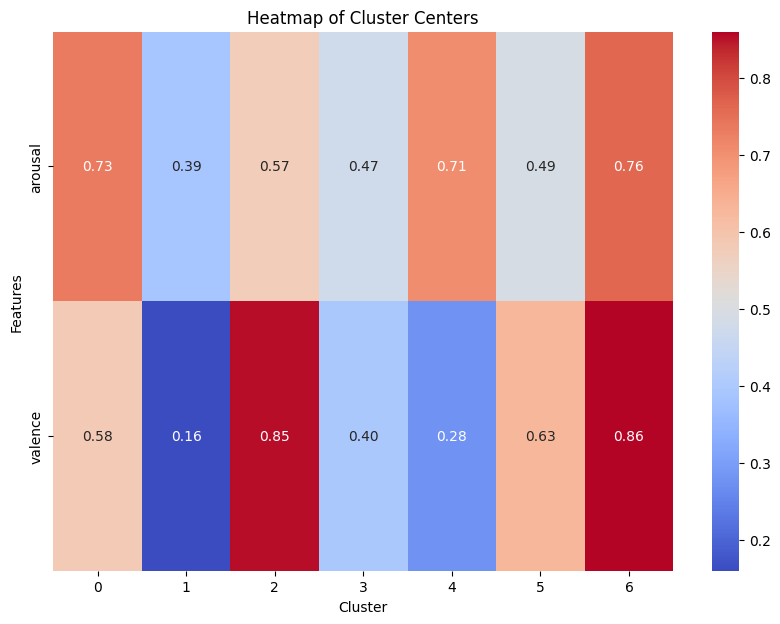

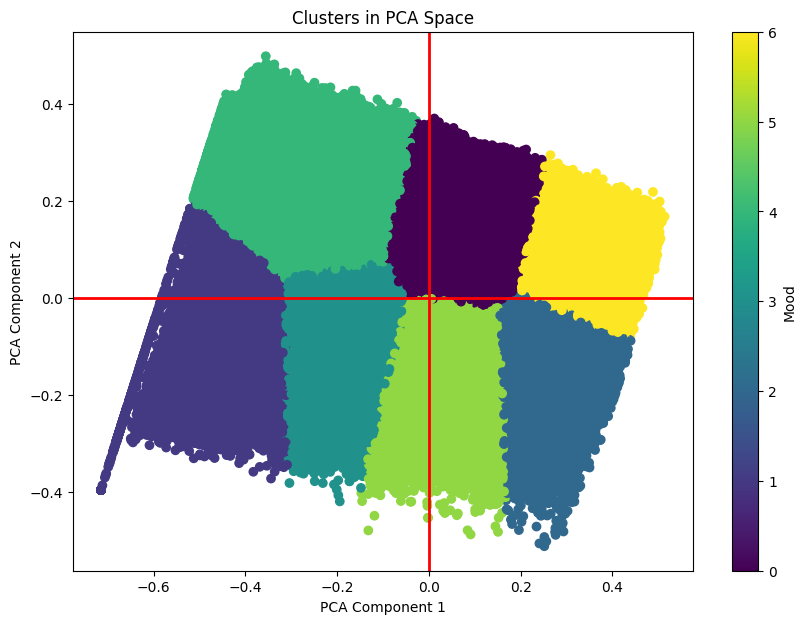

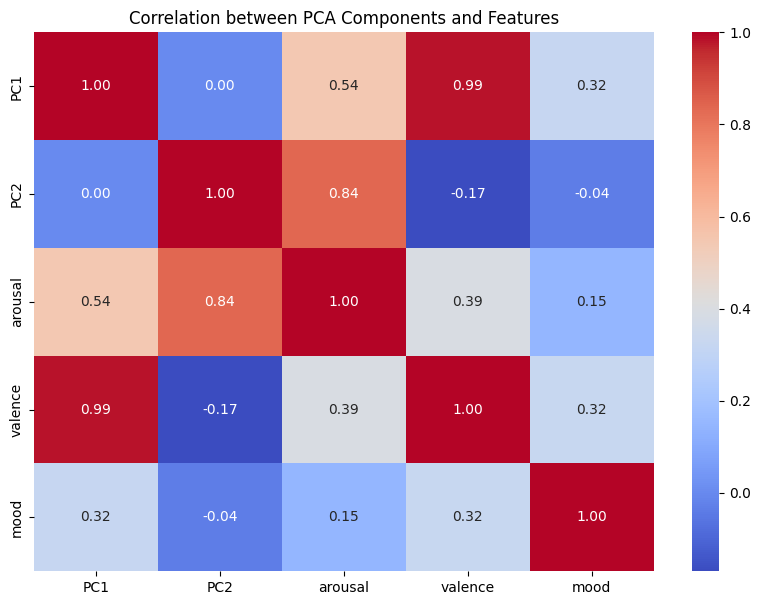

Completed K-Means for k=7 in 31.96 seconds


Running K-Means for k=8


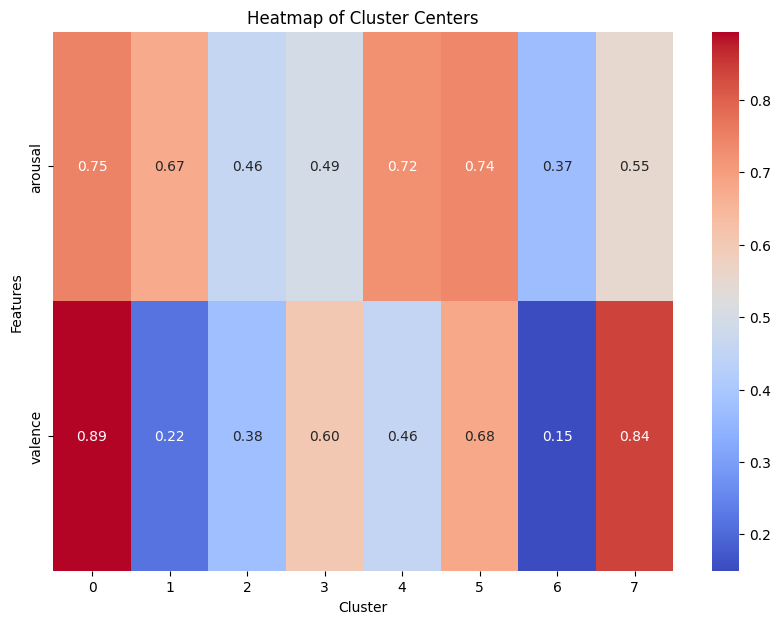

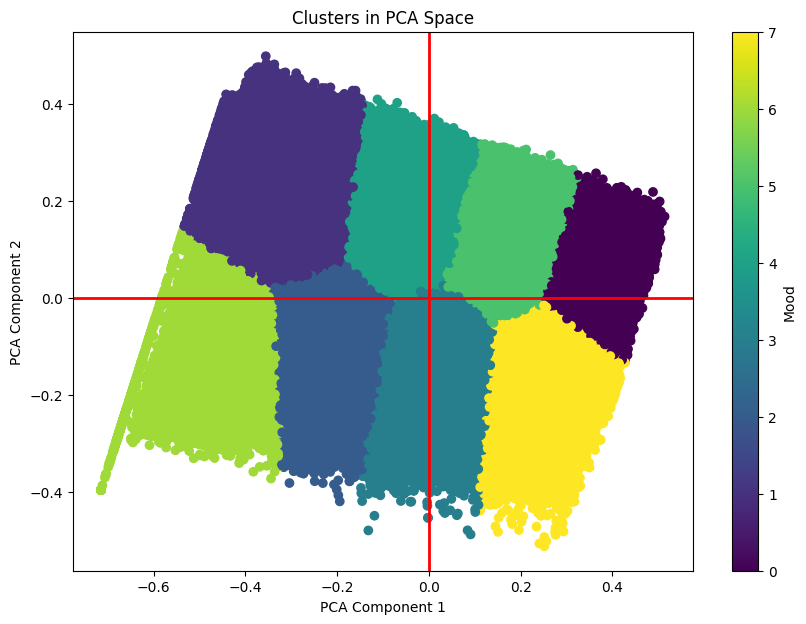

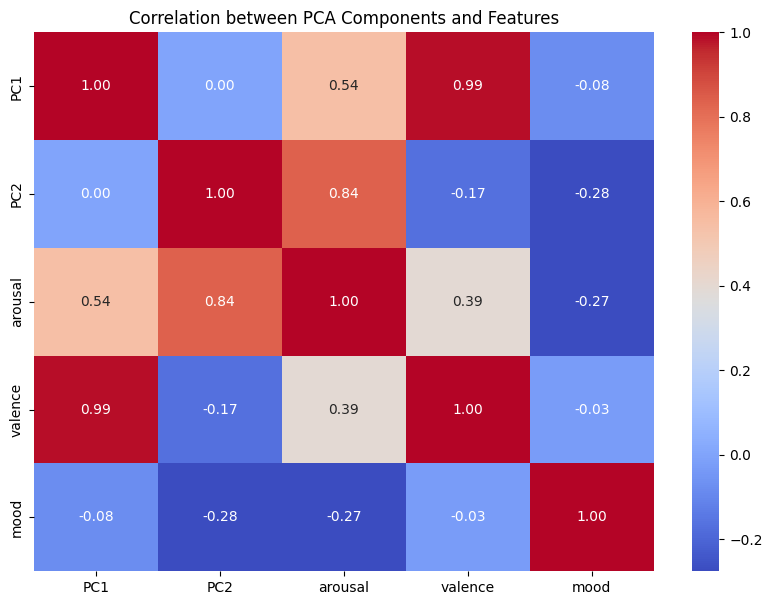

Completed K-Means for k=8 in 31.96 seconds


Running K-Means for k=9


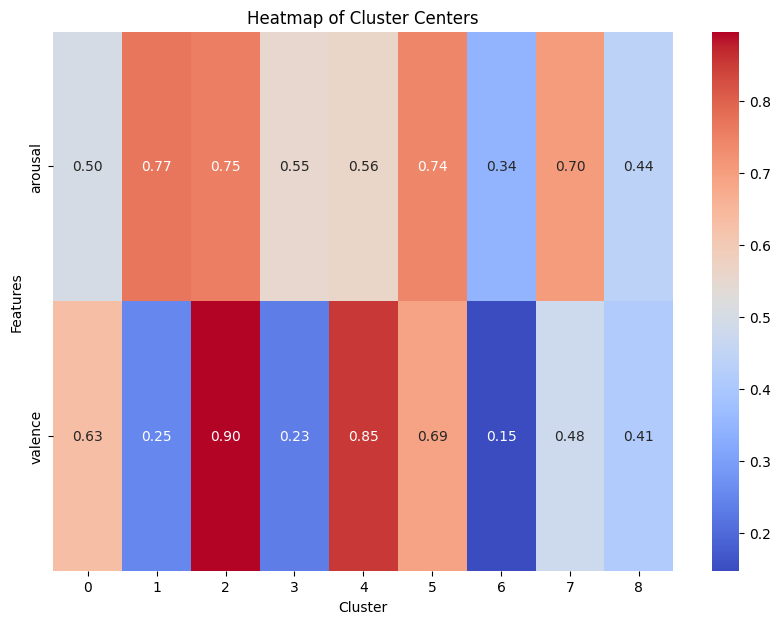

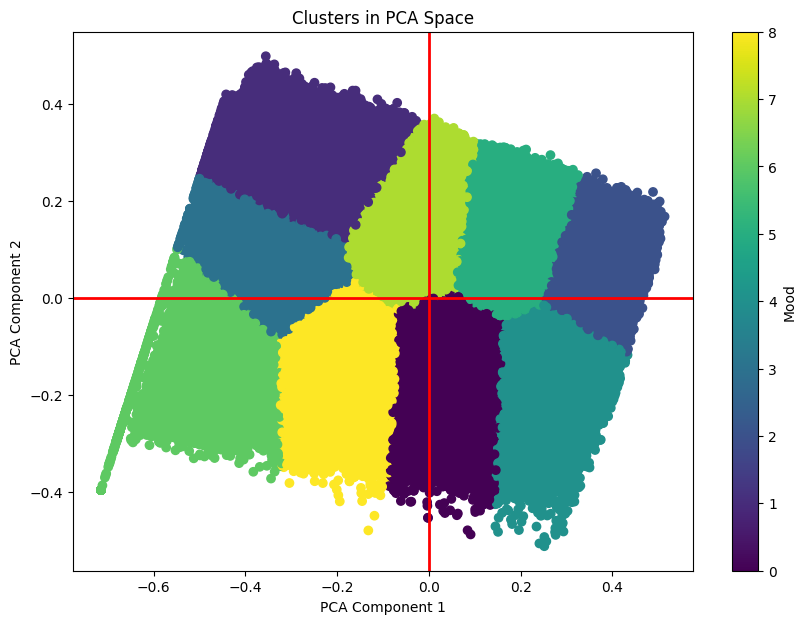

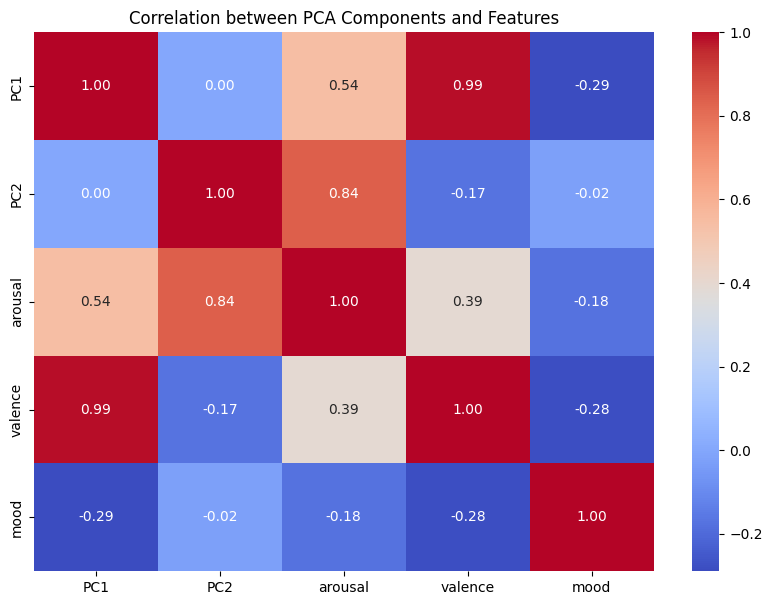

Completed K-Means for k=9 in 38.48 seconds


Running K-Means for k=10


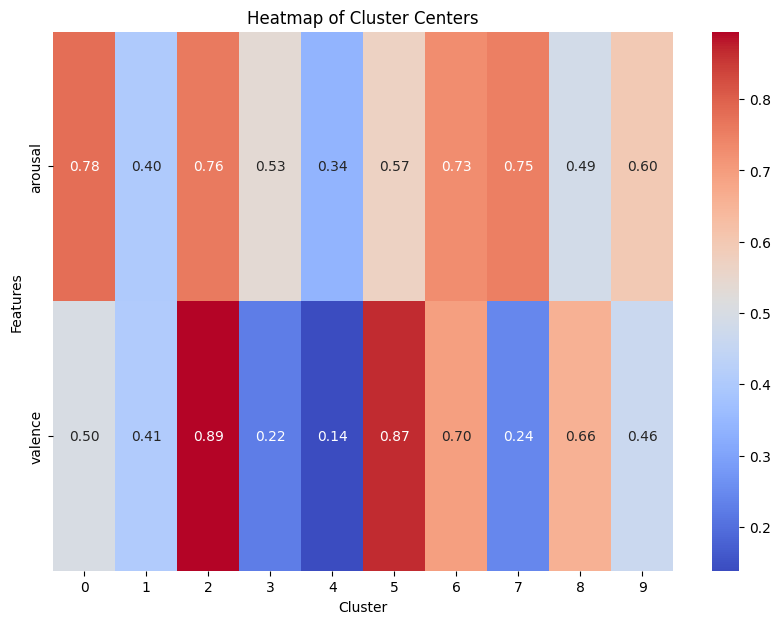

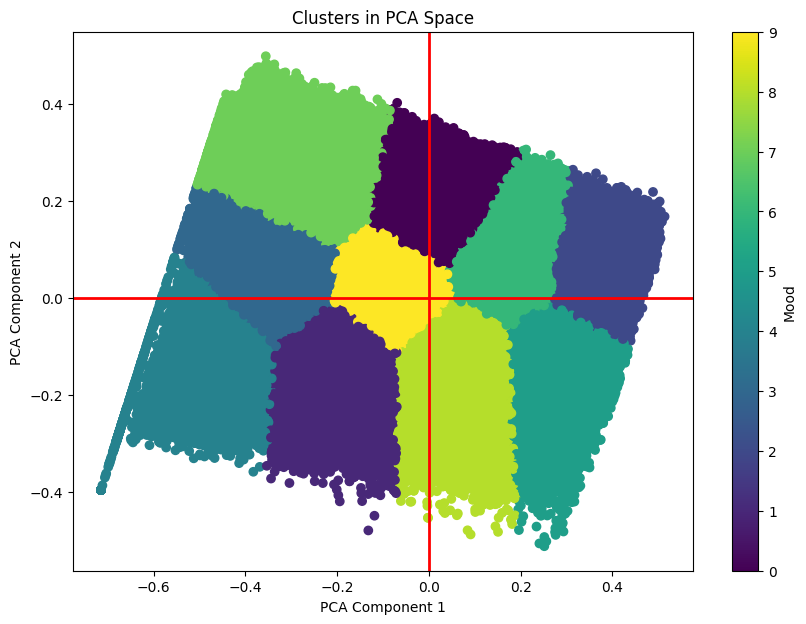

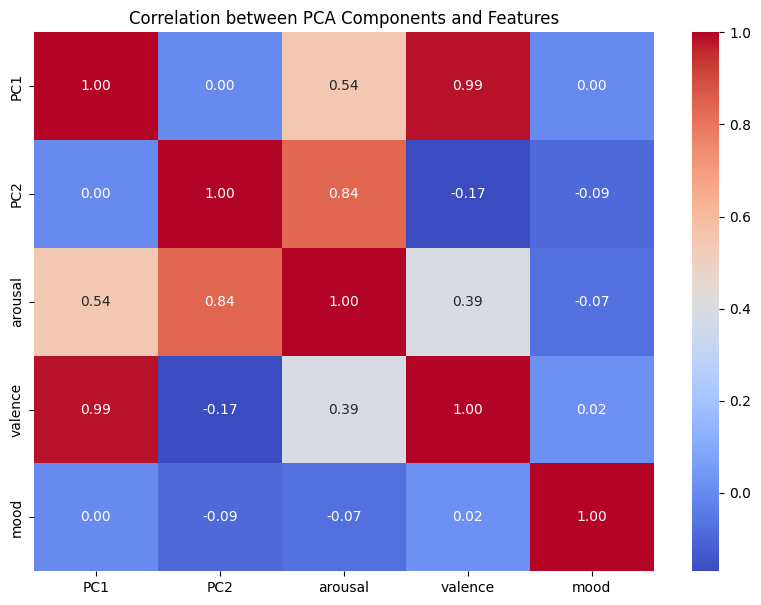

Completed K-Means for k=10 in 35.60 seconds


Running K-Means for k=11


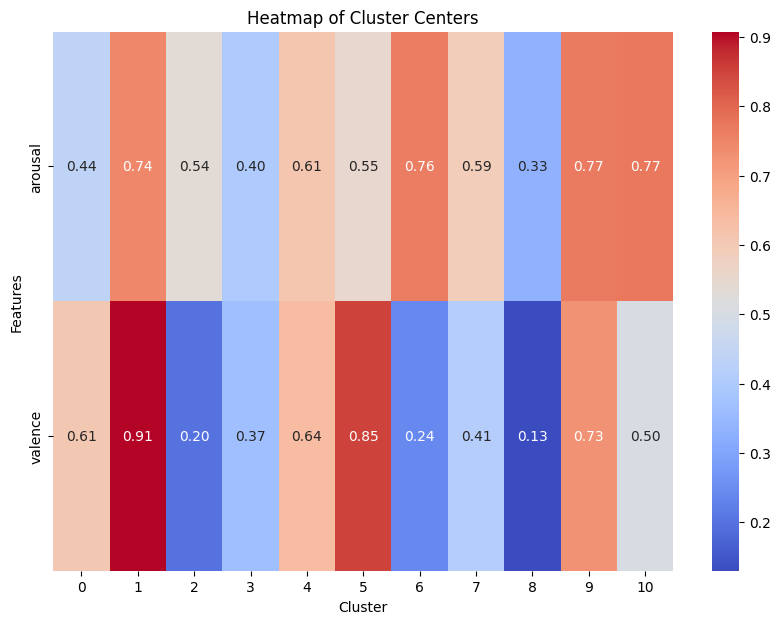

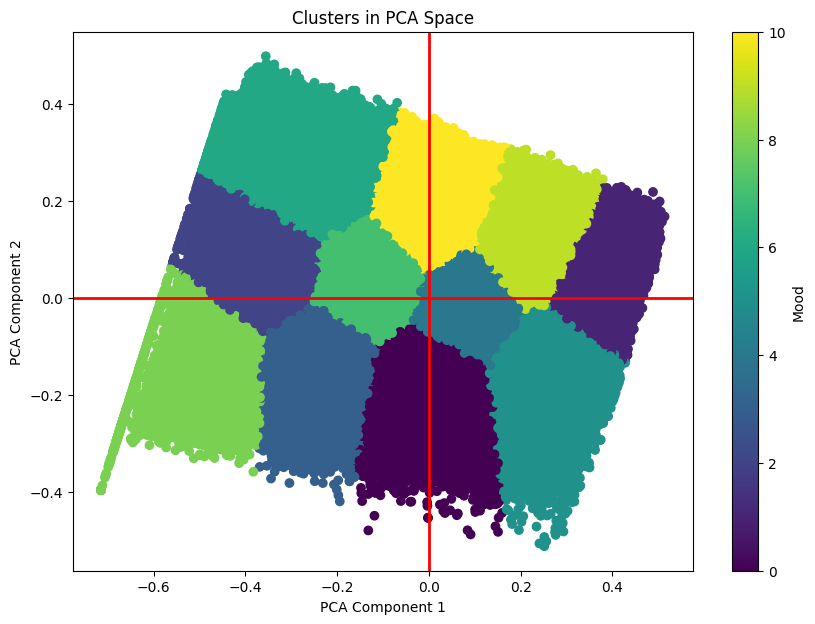

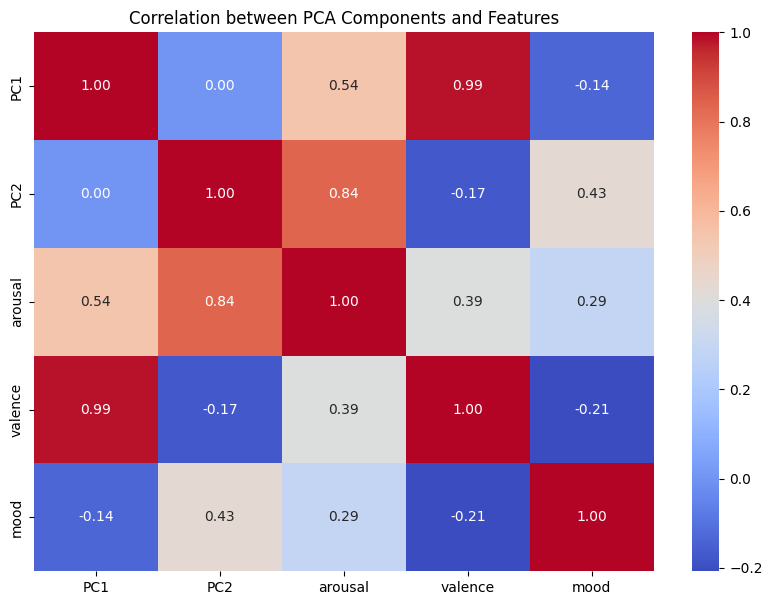

Completed K-Means for k=11 in 37.69 seconds


Running K-Means for k=12


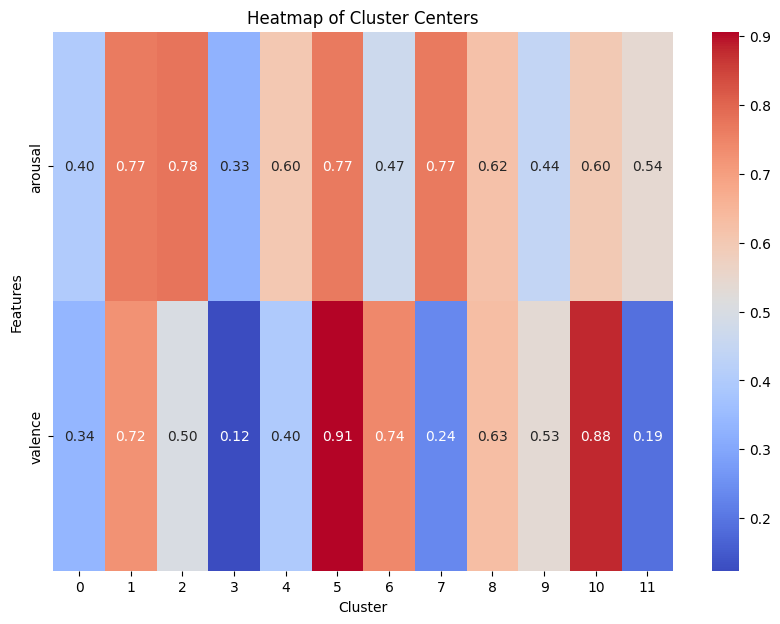

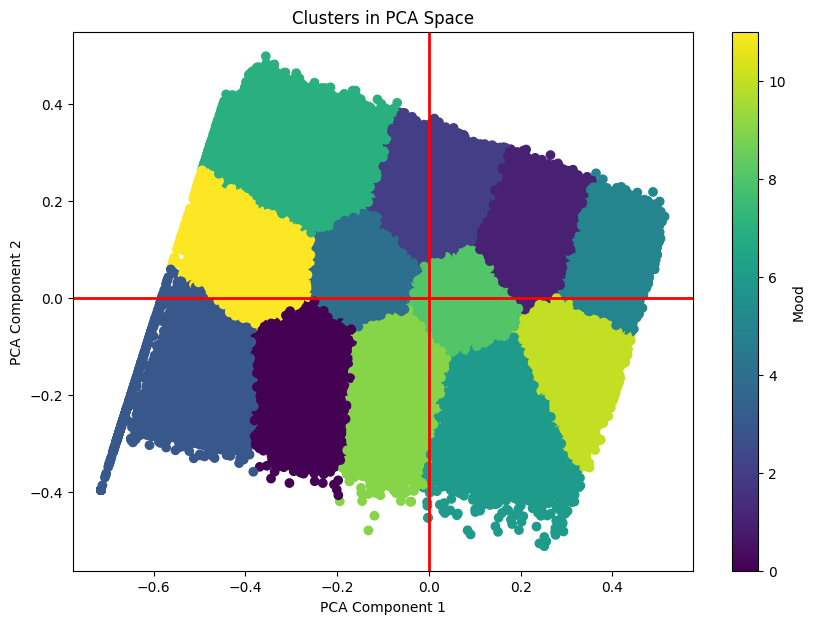

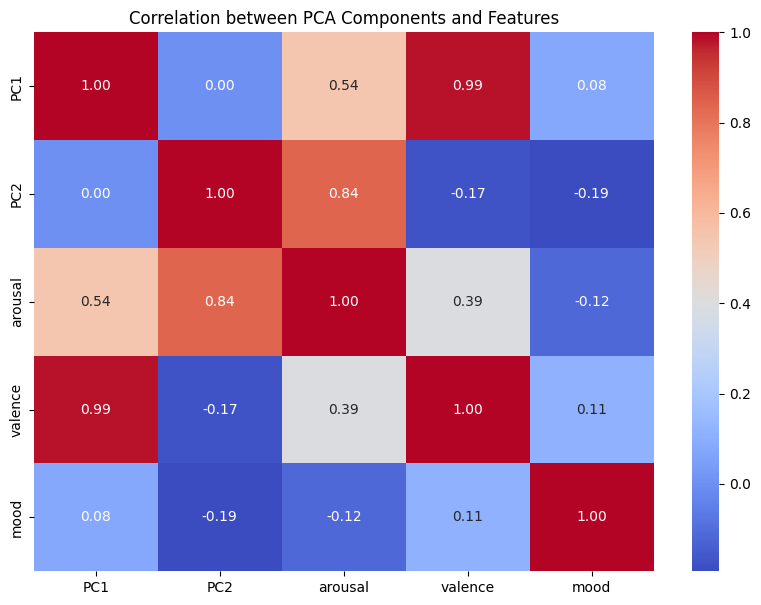

Completed K-Means for k=12 in 38.31 seconds


Running K-Means for k=13


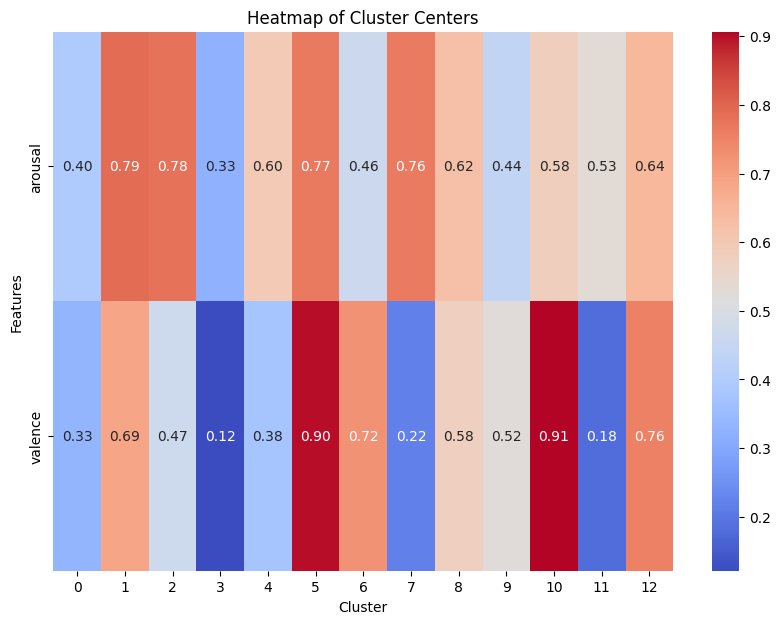

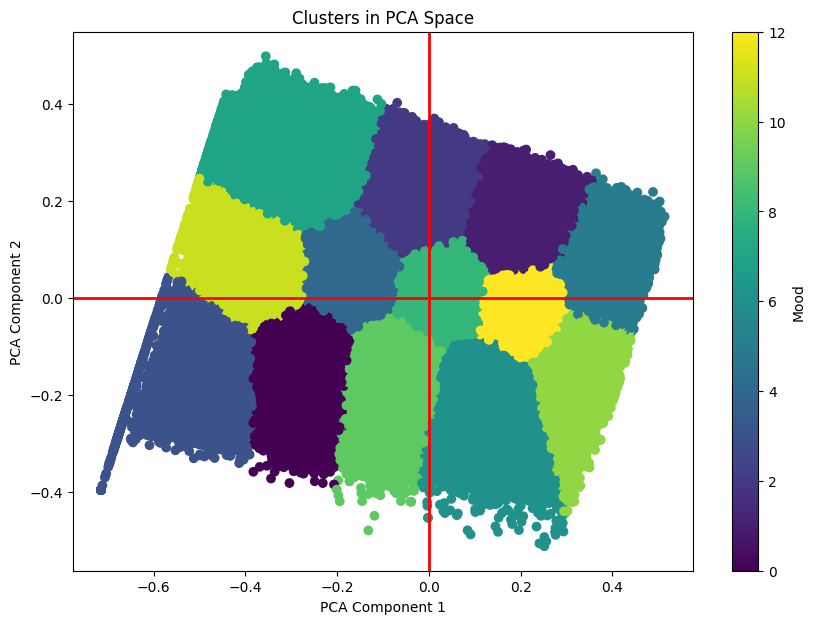

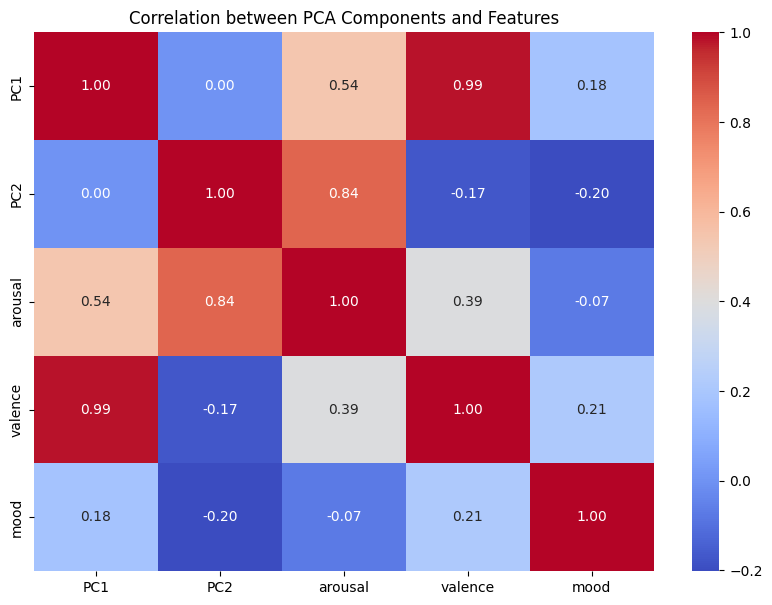

Completed K-Means for k=13 in 38.24 seconds


Running K-Means for k=14


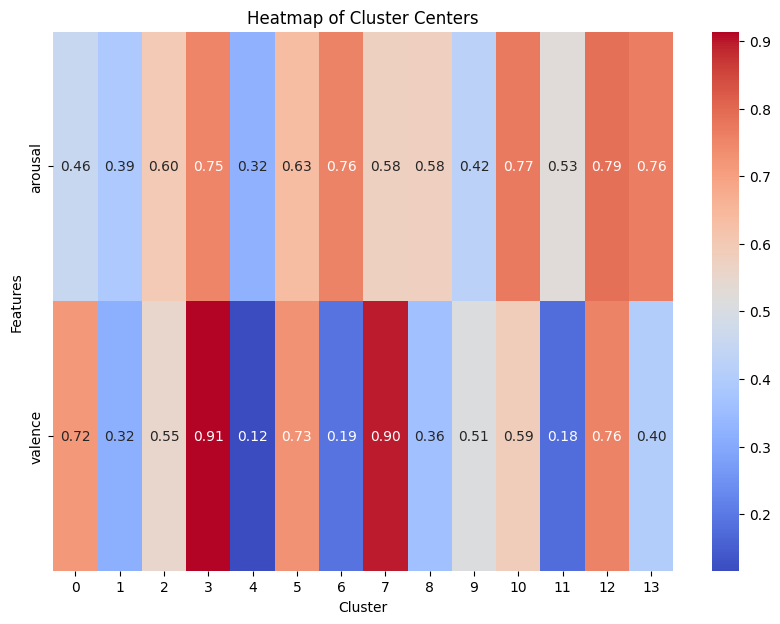

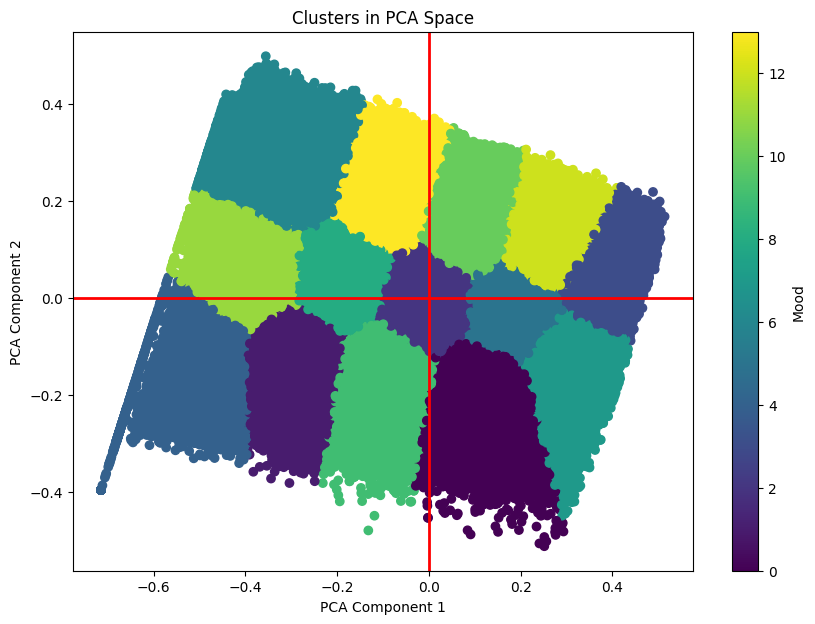

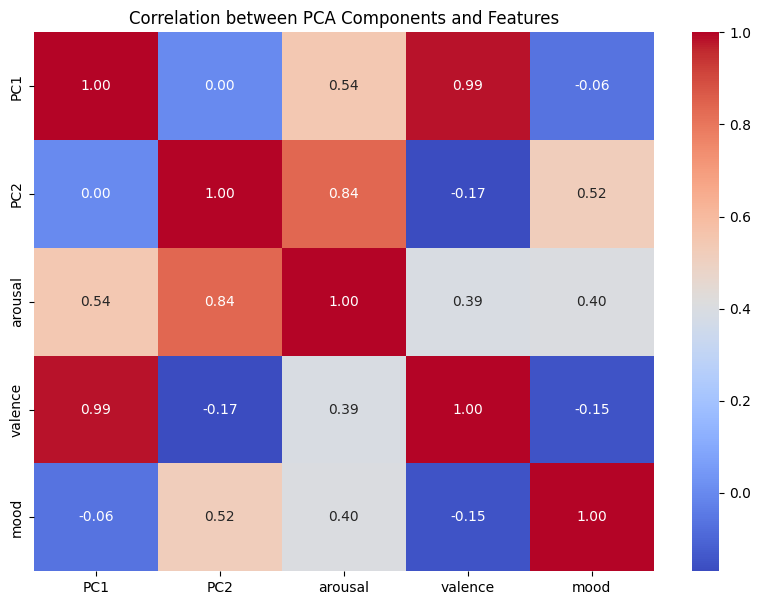

Completed K-Means for k=14 in 41.53 seconds


Running K-Means for k=15


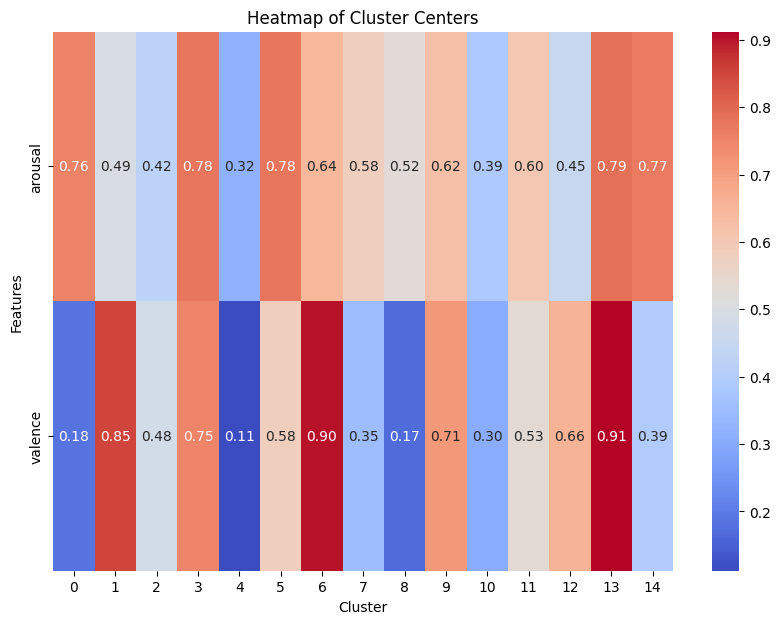

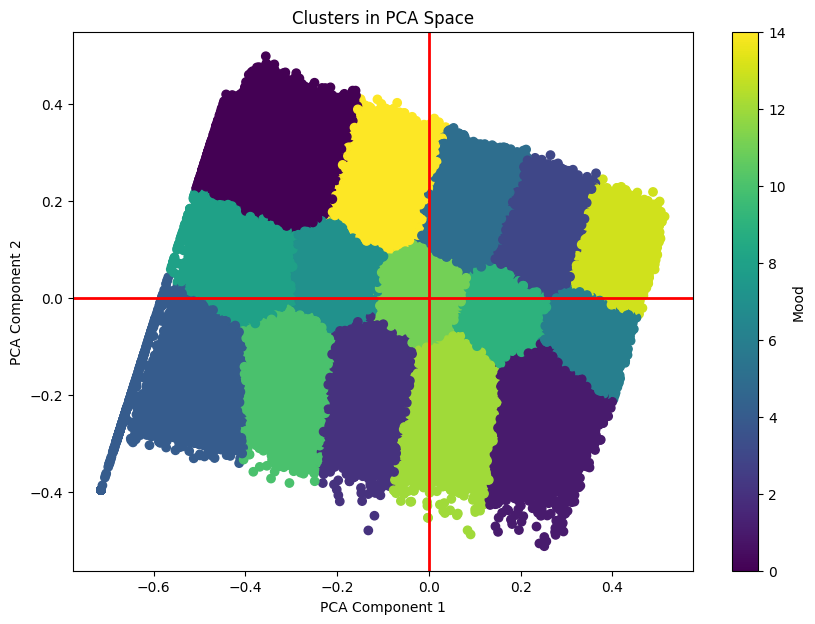

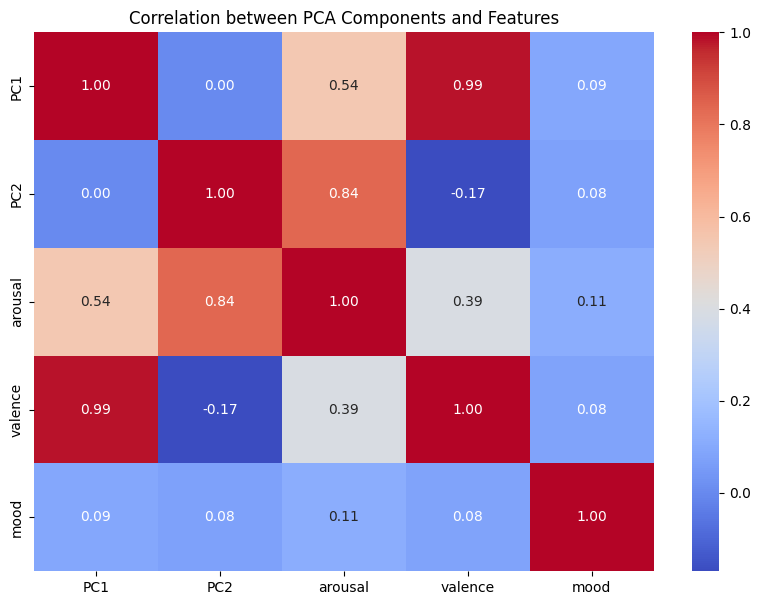

Completed K-Means for k=15 in 41.45 seconds


Running K-Means for k=16


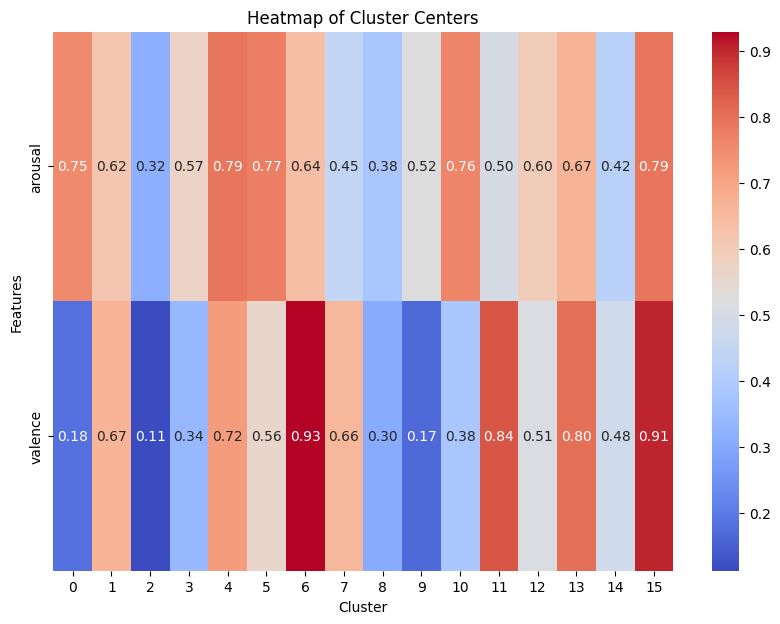

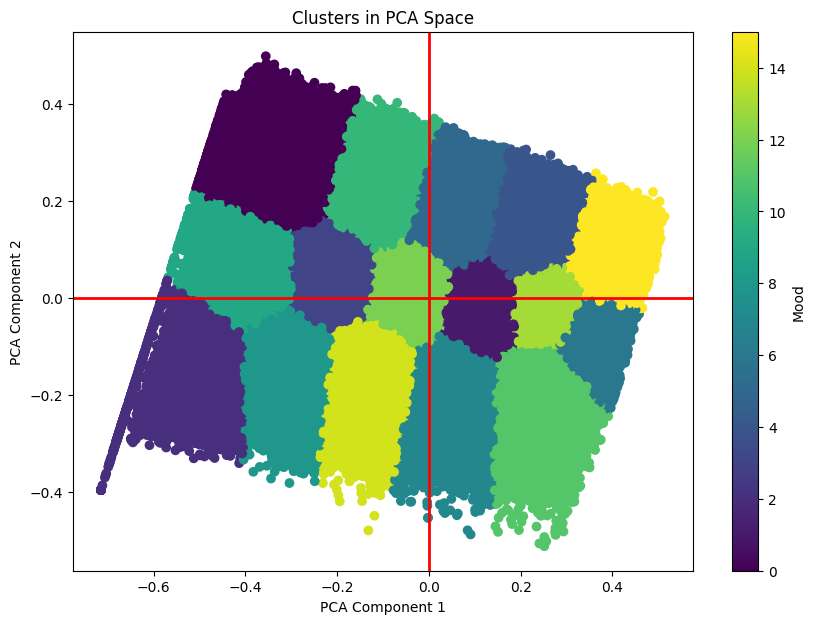

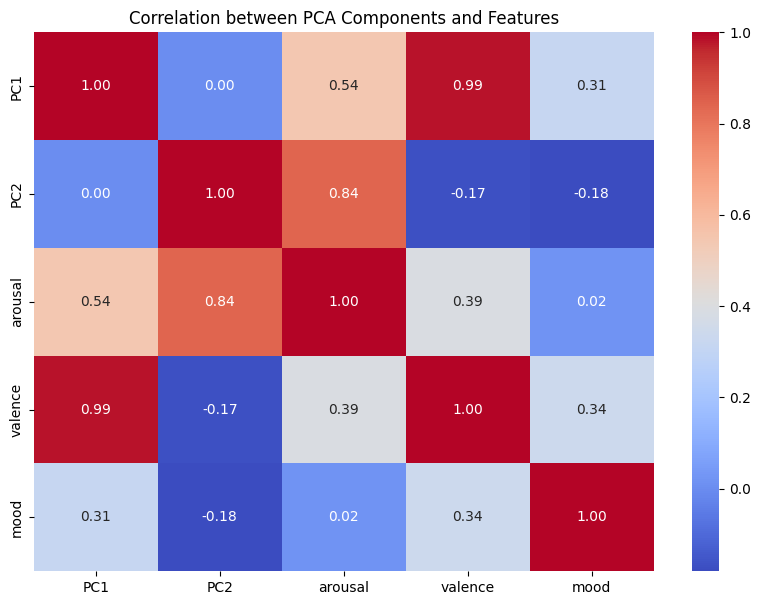

Completed K-Means for k=16 in 42.20 seconds



In [61]:
# define range
range_cluster = range(2, 17)

def kmeans_clustering_analysis(k_range: range, data_scaled_pkl: str):
    # Load the data
    data_scaled= joblib.load(data_scaled_pkl)

    # Get the shape of the data
    num_rows, _ = data_scaled.shape
    sample_sil = round((num_rows-1)*0.05)  # 5% of the dataset for silhouette score

    # Initialize result containers
    wcss_results = []
    sil_results = []
    ch_results = []
    db_results = []

    # Range of K to test
    
    print(f"Running KMeans for k = {list(k_range)} Clusters")

    # Loop through the different values of k
    for k in k_range:
        print(f"\nRunning K-Means for k={k}")
        start_time = time.time()

        # Remove the 'mood' column from previous iteration (if it exists)
        if 'mood' in data_scaled.columns:
            data_scaled = data_scaled.drop(columns=['mood'])

        # Fit the KMeans model
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit_predict(data_scaled)

        # Store the results
        wcss_results.append(kmeans.inertia_)
        sil_score = silhouette_score(
            data_scaled,
            kmeans.labels_,
            metric='euclidean',
            sample_size=sample_sil, 
            random_state=42,
            n_jobs=-1
        )
        sil_results.append(sil_score)
        ch_score = calinski_harabasz_score(data_scaled, kmeans.labels_)
        ch_results.append(ch_score)
        db_score = davies_bouldin_score(data_scaled, kmeans.labels_)
        db_results.append(db_score)

        # Add the 'mood' column to the dataframe based on the cluster labels
        data_scaled['mood'] = kmeans.labels_

        # 1. Plotting the heatmap of the clusters first (based on mood)
        plt.figure(figsize=(10, 7))
        sns.heatmap(data_scaled.groupby('mood').mean().T, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Heatmap of Cluster Centers')
        plt.ylabel('Features')
        plt.xlabel('Cluster')
        plt.show()

        # 2. Plotting the clusters in PCA space (after the heatmap)
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(data_scaled[['arousal', 'valence']])
        plt.figure(figsize=(10, 7))
        plt.scatter(pca_result[:, 0], pca_result[:, 1], c=data_scaled['mood'], cmap='viridis')
        plt.title('Clusters in PCA Space')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.axhline(0, color='r', linewidth=2)
        plt.axvline(0, color='r', linewidth=2)
        plt.colorbar(label='Mood')
        plt.show()

        # 3. Plotting the heatmap of the correlation between PCA components and features
        pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
        pca_df = pd.concat([pca_df, data_scaled], axis=1)
        correlation_matrix = pca_df.corr()
        plt.figure(figsize=(10, 7))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title("Correlation between PCA Components and Features")
        plt.show()

        print(f"Completed K-Means for k={k} in {time.time() - start_time:.2f} seconds\n")

    # Return the results as a DataFrame
    all_results = pd.DataFrame({
        'k': list(k_range),
        'WCSS': wcss_results,
        'Silhouette Score': sil_results,
        'Calinski-Harabasz': ch_results,
        'Davies-Bouldin': db_results
    })
    
    return all_results

results_kmeans = kmeans_clustering_analysis(range_cluster, data_scaled_pkl)

### Resultados para la eleccion del numero de cluster ideal


 k        WCSS  Silhouette Score  Calinski-Harabasz  Davies-Bouldin
 2 22948.25530           0.47110       774903.39569         0.79710
 3 16568.82965           0.37349       649578.92297         0.97263
 4 12468.00796           0.38965       639806.80015         0.86857
 5  9966.96910           0.37286       637073.83794         0.86303
 6  8197.76896           0.36788       644973.37329         0.81891
 7  7243.01763           0.34415       621218.35450         0.88036
 8  6285.03156           0.34657       626411.11680         0.84157
 9  5689.68373           0.34009       613131.21339         0.85399
10  5132.59791           0.34164       611239.20017         0.84499
11  4656.43649           0.34445       612366.50541         0.82547
12  4253.82524           0.34374       614432.11792         0.80564
13  3920.16111           0.34992       615330.92425         0.78589
14  3651.29945           0.34093       613137.58138         0.79296
15  3417.64714           0.33531       611133.8

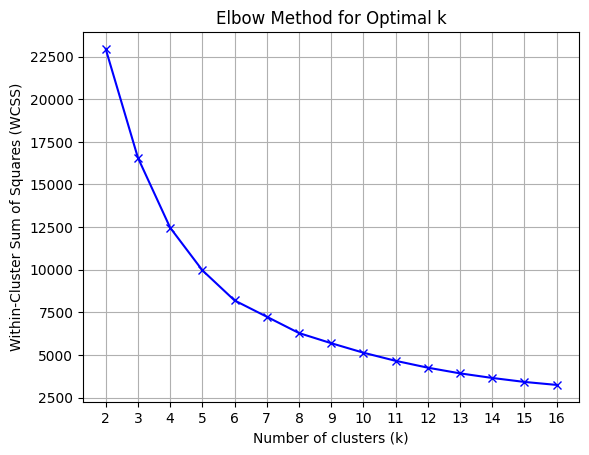

In [63]:
# Print Results of the Kmeans
print(f"\n{results_kmeans.round(5).to_string(index=False)}\n")

# Find the best k for each metric
best_k_wcss = results_kmeans.loc[results_kmeans['WCSS'].idxmin()]['k']
best_k_silhouette = results_kmeans.loc[results_kmeans['Silhouette Score'].idxmax()]['k']
best_k_calinski = results_kmeans.loc[results_kmeans['Calinski-Harabasz'].idxmax()]['k']
best_k_davies = results_kmeans.loc[results_kmeans['Davies-Bouldin'].idxmin()]['k']
best_k_knee = KneeLocator(list(range_cluster), results_kmeans['WCSS'], curve='convex', direction='decreasing',S=1)

# Print the results
print(f"Best k based on WCSS: k = {best_k_wcss}")
print(f"Best k based on Silhouette Score: k = {best_k_silhouette}")
print(f"Best k based on Calinski-Harabasz: k = {best_k_calinski}")
print(f"Best k based on Davies-Bouldin: k = {best_k_davies}")
print(f"Best k based on KneeLocator: k = {best_k_knee.knee}")

# Plotting the Elbow Method
plt.plot(list(range_cluster), results_kmeans['WCSS'], 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.xticks(range_cluster)
plt.grid()

# Display the plot
plt.show()

### Seleccionamos el cluster ideal y explicamos el porque

In [6]:
# El numero de cluster elejido
best_k = 4

### Correr el Kmeans con el numero de clusters elejidos y explicar porque lo elegimos

K-means Training (Get Clusters)
Model saved to: ./Models/model_kmeans.pkl
Scaled labeled data saved to: ./Data/data_scaled_labeled.pkl


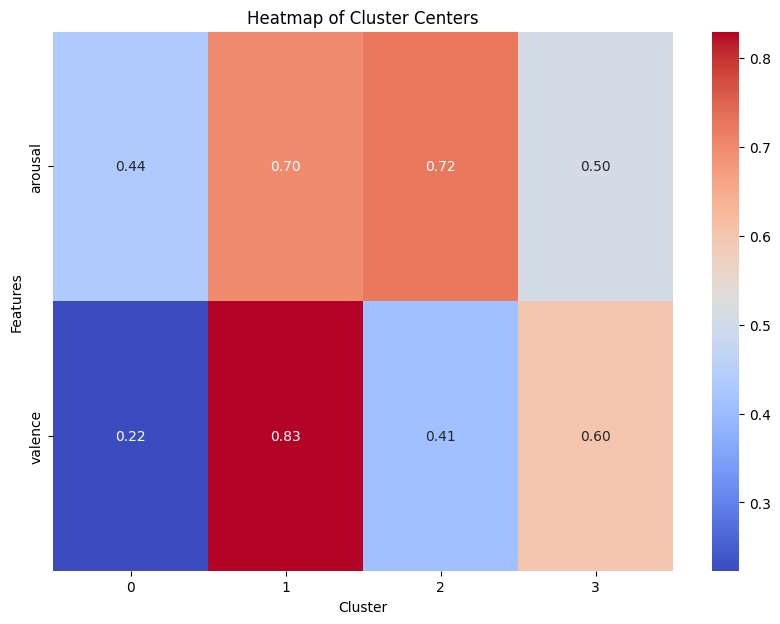

Completed in 2.22 seconds




In [21]:
# Run Kmeans Clustering for selected cluster number
def train_kmeans(k_in: int, scaled_input_pkl: str, scaled_labeled_output_pkl: str, model_output_pkl: str):

    start_time = time.time()

    print(f"K-means Training (Get Clusters)")

    data_scaled = joblib.load(scaled_input_pkl)
    kmeans = KMeans(n_clusters=k_in, random_state=42, n_init=10)
    data_scaled['mood'] = kmeans.fit_predict(data_scaled)

    joblib.dump(kmeans, model_output_pkl)
    joblib.dump(data_scaled, scaled_labeled_output_pkl)

    print(f"Model saved to: {model_output_pkl}")
    print(f"Scaled labeled data saved to: {scaled_labeled_output_pkl}")

    # Plotting the heatmap of the clusters first (based on mood)
    plt.figure(figsize=(10, 7))

    # Group by the 'mood' column and calculate the mean for each cluster (feature-wise)
    # Transpose the result for better visualization (features as rows, clusters as columns)
    sns.heatmap(data_scaled.groupby('mood').mean().T, annot=True, cmap='coolwarm', fmt=".2f")

    # Adding labels and title
    plt.title('Heatmap of Cluster Centers')
    plt.ylabel('Features')
    plt.xlabel('Cluster')

    # Show the plot
    plt.show()

    print(f"Completed in {time.time() - start_time:.2f} seconds\n\n")

train_kmeans(best_k, data_scaled_pkl, data_scaled_labeled_pkl, model_kmeans_pkl)

### Separar el dataset en Train y Test

In [8]:
# Save Train and Test Vectors
def save_train_and_test_data(scaled_labeled_input_pkl: str, train_data_pkl: str, test_data_pkl: str):

    start_time = time.time()

    print("Splitting and saving train/test data")

    df = joblib.load(scaled_labeled_input_pkl)
    x = df.drop(columns=["mood"])
    y = df["mood"]

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42, stratify=y
    )

    joblib.dump((x_train, y_train), train_data_pkl)
    joblib.dump((x_test, y_test), test_data_pkl)

    print(f"Train data saved to: {train_data_pkl}")
    print(f"Test data saved to: {test_data_pkl}")
    
    print(f"Completed in {time.time() - start_time:.2f} seconds\n\n")

save_train_and_test_data(data_scaled_labeled_pkl, data_train_pkl, data_test_pkl)

Splitting and saving train/test data
Train data saved to: ./Data/data_train.pkl
Test data saved to: ./Data/data_test.pkl
Completed in 0.27 seconds




### Random Forest Model Training

In [38]:
# RANDOM FOREST MODEL
def train_random_forest(train_data_pkl: str, model_output_pkl: str, grid_output_pkl: str):
    start_time = time.time()

    print(f"Random Forest Model Training")

    x_train, y_train = joblib.load(train_data_pkl)

    model = RandomForestClassifier(random_state=42)

    param_grid = {
        'n_estimators': [100],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt'],
    }

    grid_search = GridSearchCV(
        model, 
        param_grid, 
        cv=3, 
        scoring='accuracy', 
        n_jobs=-1, 
        verbose=1
    )
    
    grid_search.fit(x_train, y_train)
    joblib.dump(grid_search, grid_output_pkl)

    best_model = grid_search.best_estimator_
    joblib.dump(best_model, model_output_pkl)

    print(f"Model saved to: {model_output_pkl}")
    print(f"Grid saved to: {grid_output_pkl}")

    print(f"Completed in {time.time() - start_time:.2f} seconds\n\n")

# Train Random Forest using scaled labeled data
train_random_forest(data_train_pkl, model_random_forest_pkl, model_grid_random_forest_pkl)

Random Forest Model Training
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Model saved to: ./Models/model_random_forest.pkl
Grid saved to: ./Models/model_grid_random_forest.pkl
Completed in 140.67 seconds




### KNN Model Training

In [32]:
# KNN MODEL
def train_knn(train_data_pkl: str, model_output_pkl: str, grid_output_pkl: str):
    start_time = time.time()

    print(f"KNN Model Training")

    x_train, y_train = joblib.load(train_data_pkl)

    model = KNeighborsClassifier()

    param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'p': [2]
    }

    grid_search = GridSearchCV(
        model, 
        param_grid, 
        cv=3, 
        scoring='accuracy', 
        n_jobs=-1, 
        verbose=1
    )

    grid_search.fit(x_train, y_train)
    joblib.dump(grid_search, grid_output_pkl)

    best_model = grid_search.best_estimator_
    joblib.dump(best_model, model_output_pkl)

    print(f"Model saved to: {model_output_pkl}")
    print(f"Grid saved to: {grid_output_pkl}")

    print(f"Completed in {time.time() - start_time:.2f} seconds\n\n")

# Train KNN using scaled labeled data
train_knn(data_train_pkl, model_knn_pkl, model_grid_knn_pkl)

KNN Model Training
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Model saved to: ./Models/model_knn.pkl
Grid saved to: ./Models/model_grid_knn.pkl
Completed in 42.81 seconds




### Logistic Regression Model Training

In [33]:
# LOGISTIC REGRESSION MODEL
def train_logistic_regression(train_data_pkl: str, model_output_pkl: str, grid_output_pkl: str):
    start_time = time.time()

    print(f"Logistic Regression Model Training")

    x_train, y_train = joblib.load(train_data_pkl)

    model = LogisticRegression(max_iter=1000)

    param_grid = {
        'C': [0.1, 1, 10],
        'solver': ['lbfgs'],
        'penalty': ['l2'],
    }

    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(x_train, y_train)
    joblib.dump(grid_search, grid_output_pkl)

    best_model = grid_search.best_estimator_
    joblib.dump(best_model, model_output_pkl)

    print(f"Model saved to: {model_output_pkl}")
    print(f"Grid saved to: {grid_output_pkl}")
    
    print(f"Completed in {time.time() - start_time:.2f} seconds\n\n")

# Train Logistic Regression using scaled labeled data
train_logistic_regression(data_train_pkl, model_logistic_regression_pkl, model_grid_logistic_regression_pkl)

Logistic Regression Model Training
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Model saved to: ./Models/model_logistic_regression.pkl
Grid saved to: ./Models/model_grid_logistic_regression.pkl
Completed in 12.55 seconds




### SVC Model Training

In [35]:
# SVC MODEL
def train_svc(train_data_pkl: str, model_output_pkl: str, grid_output_pkl: str):
    start_time = time.time()

    print(f"SVC Model Training")

    x_train, y_train = joblib.load(train_data_pkl)

    model = SVC(probability=False) 

    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear']
    }

    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(x_train, y_train)
    joblib.dump(grid_search, grid_output_pkl)

    best_model = grid_search.best_estimator_
    joblib.dump(best_model, model_output_pkl)

    print(f"Model saved to: {model_output_pkl}")
    print(f"Grid saved to: {grid_output_pkl}")

    print(f"Completed in {time.time() - start_time:.2f} seconds\n\n")

# Train SVC using scaled labeled data
train_svc(data_train_pkl, model_svc_pkl, model_grid_svc_pkl)


SVC Model Training
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Model saved to: ./Models/model_svc.pkl
Grid saved to: ./Models/model_grid_svc.pkl
Completed in 1068.35 seconds




### Hist Gradient Boost Model Training

In [36]:
# HIST GRADIENT BOOST MODEL
def train_hist_gradient_boost(train_data_pkl: str, model_output_pkl: str, grid_output_pkl: str):
    start_time = time.time()
    
    print(f"Hist Gradient Boosting Model Training")

    x_train, y_train = joblib.load(train_data_pkl)

    model = HistGradientBoostingClassifier(random_state=42)

    param_grid = {
        'max_iter': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    }

    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(x_train, y_train)
    joblib.dump(grid_search, grid_output_pkl)

    best_model = grid_search.best_estimator_
    joblib.dump(best_model, model_output_pkl)

    print(f"Model saved to: {model_output_pkl}")
    print(f"Grid saved to: {grid_output_pkl}")

    print(f"Completed in {time.time() - start_time:.2f} seconds\n\n")

# Train Hist Gradient Boost using scaled labeled data
train_hist_gradient_boost(data_train_pkl, model_hist_gradient_boost_pkl, model_grid_hist_gradient_boost_pkl)

Hist Gradient Boosting Model Training
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Model saved to: ./Models/model_hist_gradient_boost.pkl
Grid saved to: ./Models/model_grid_hist_gradient_boost.pkl
Completed in 137.72 seconds




### XGBoost Model Training

In [39]:
# XGBOOST MODEL
def train_xgboost(train_data_pkl: str, model_output_pkl: str, grid_output_pkl: str):
    start_time = time.time()

    print(f"XGBoost Model Training")

    x_train, y_train = joblib.load(train_data_pkl)

    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        verbosity=0,
        random_state=42
    )

    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    }

    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(x_train, y_train)
    joblib.dump(grid_search, grid_output_pkl)

    best_model = grid_search.best_estimator_
    joblib.dump(best_model, model_output_pkl)

    print(f"Model saved to: {model_output_pkl}")
    print(f"Grid saved to: {grid_output_pkl}")
    
    print(f"Completed in {time.time() - start_time:.2f} seconds\n\n")

# Train XGBoost using scaled labeled data
train_xgboost(data_train_pkl, model_xgboost_pkl, model_grid_xgboost_pkl)

XGBoost Model Training
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Model saved to: ./Models/model_xgboost.pkl
Grid saved to: ./Models/model_grid_xgboost.pkl
Completed in 86.47 seconds




### Evaluacion de modelos con el vector de Test

Evaluating Random Forest on test data
Random Forest | Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest | Best Grid Accuracy: 0.99903
Random Forest | Test Accuracy: 0.99932
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26014
           1       1.00      1.00      1.00     39667
           2       1.00      1.00      1.00     25566
           3       1.00      1.00      1.00     26088

    accuracy                           1.00    117335
   macro avg       1.00      1.00      1.00    117335
weighted avg       1.00      1.00      1.00    117335



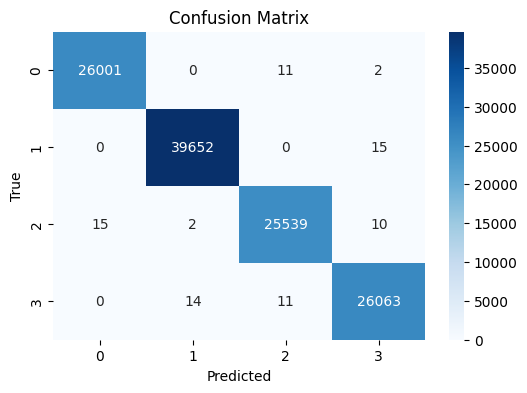

Random Forest evaluation completed in 1.05 seconds 


Evaluating KNN on test data
KNN | Best Params: {'n_neighbors': 9, 'p': 2, 'weights': 'distance'}
KNN | Best Grid Accuracy: 0.99912
KNN | Test Accuracy: 0.99944
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26014
           1       1.00      1.00      1.00     39667
           2       1.00      1.00      1.00     25566
           3       1.00      1.00      1.00     26088

    accuracy                           1.00    117335
   macro avg       1.00      1.00      1.00    117335
weighted avg       1.00      1.00      1.00    117335



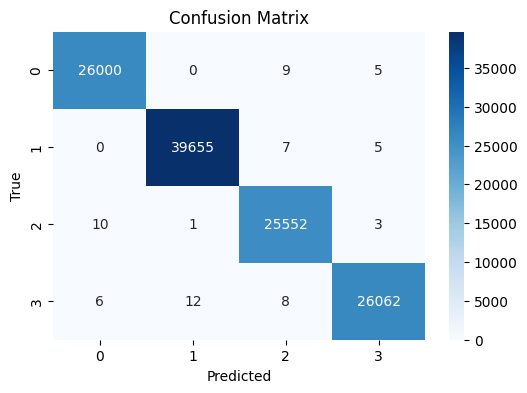

KNN evaluation completed in 1.02 seconds 


Evaluating Logistic Regression on test data
Logistic Regression | Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic Regression | Best Grid Accuracy: 0.99876
Logistic Regression | Test Accuracy: 0.99902
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26014
           1       1.00      1.00      1.00     39667
           2       1.00      1.00      1.00     25566
           3       1.00      1.00      1.00     26088

    accuracy                           1.00    117335
   macro avg       1.00      1.00      1.00    117335
weighted avg       1.00      1.00      1.00    117335



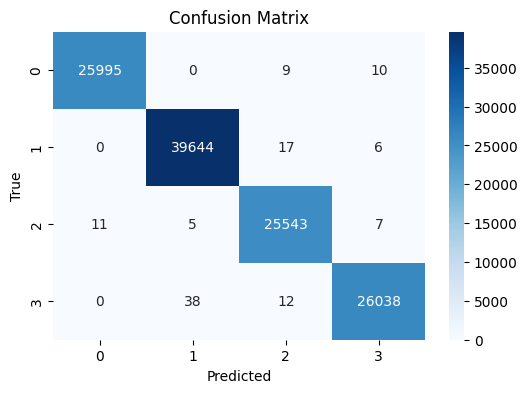

Logistic Regression evaluation completed in 0.16 seconds 


Evaluating SVC on test data
SVC | Best Params: {'C': 10, 'kernel': 'linear'}
SVC | Best Grid Accuracy: 0.99944
SVC | Test Accuracy: 0.99951
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26014
           1       1.00      1.00      1.00     39667
           2       1.00      1.00      1.00     25566
           3       1.00      1.00      1.00     26088

    accuracy                           1.00    117335
   macro avg       1.00      1.00      1.00    117335
weighted avg       1.00      1.00      1.00    117335



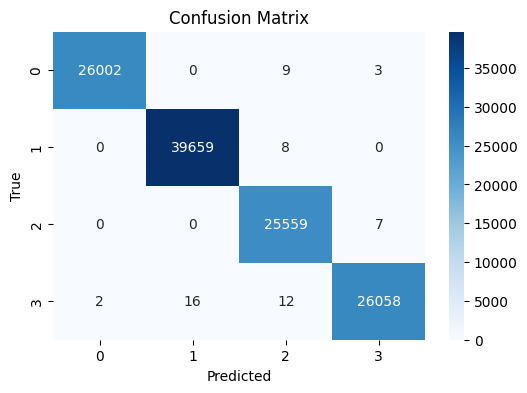

SVC evaluation completed in 24.80 seconds 


Evaluating Hist Gradient Boost on test data
Hist Gradient Boost | Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'max_iter': 200}
Hist Gradient Boost | Best Grid Accuracy: 0.99752
Hist Gradient Boost | Test Accuracy: 0.99756
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26014
           1       1.00      1.00      1.00     39667
           2       1.00      1.00      1.00     25566
           3       1.00      1.00      1.00     26088

    accuracy                           1.00    117335
   macro avg       1.00      1.00      1.00    117335
weighted avg       1.00      1.00      1.00    117335



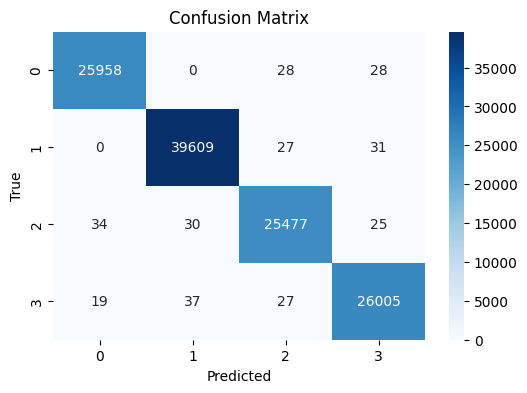

Hist Gradient Boost evaluation completed in 3.02 seconds 


Evaluating XGBoost on test data
XGBoost | Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
XGBoost | Best Grid Accuracy: 0.99747
XGBoost | Test Accuracy: 0.99761
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26014
           1       1.00      1.00      1.00     39667
           2       1.00      1.00      1.00     25566
           3       1.00      1.00      1.00     26088

    accuracy                           1.00    117335
   macro avg       1.00      1.00      1.00    117335
weighted avg       1.00      1.00      1.00    117335



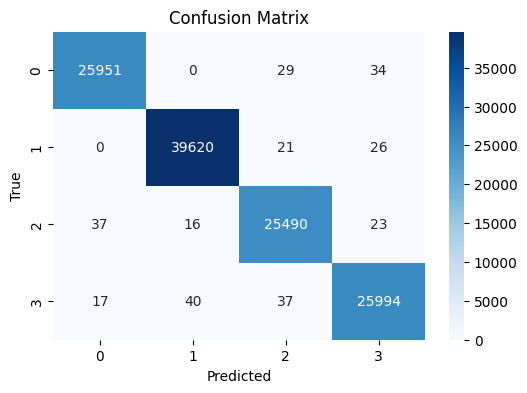

XGBoost evaluation completed in 0.48 seconds 




In [9]:
#Models Evaluation
def evaluate_model(test_data_pkl: str, model_pkl: str, grid_pkl: str, model_name: str):

    start_time = time.time()

    print(f"Evaluating {model_name} on test data")

    # Load model, grid and test data
    model = joblib.load(model_pkl)
    grid = joblib.load(grid_pkl)

    # Predict
    x_test, y_test = joblib.load(test_data_pkl)
    y_pred = model.predict(x_test)

    best_params = grid.best_params_
    best_cv_acc = grid.best_score_
    test_acc = accuracy_score(y_test, y_pred)

    # Log model parameters and scores
    print(f"{model_name} | Best Params: {best_params}")
    print(f"{model_name} | Best Grid Accuracy: {best_cv_acc:.5f}")
    print(f"{model_name} | Test Accuracy: {test_acc:.5f}")

    # Classification Report
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")  # Corrected typo
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    print(f"{model_name} evaluation completed in {time.time() - start_time:.2f} seconds \n\n")

    return {
        "Model": model_name,
        "Best Grid Accuracy": round(best_cv_acc, 5),
        "Test Accuracy": round(test_acc, 5)
    }

results_models = []

#Kmeans
#clusters_info("{path_models}data_scaled.pkl","{path_models}model_kmeans.pkl")

#'''
#Random Forest
results_models.append(evaluate_model(data_test_pkl,
                              model_random_forest_pkl,model_grid_random_forest_pkl,
                              f"Random Forest"))

#KNN
results_models.append(evaluate_model(data_test_pkl,
                              model_knn_pkl,model_grid_knn_pkl,
                              f"KNN"))

#Logistic Regression
results_models.append(evaluate_model(data_test_pkl,
                              model_logistic_regression_pkl,model_grid_logistic_regression_pkl,
                              f"Logistic Regression"))

#SVC
results_models.append(evaluate_model(data_test_pkl,
                              model_svc_pkl,model_grid_svc_pkl,
                              f"SVC"))

#Hist Gradient Boost
results_models.append(evaluate_model(data_test_pkl,
                              model_hist_gradient_boost_pkl,model_grid_hist_gradient_boost_pkl,
                              f"Hist Gradient Boost"))

#XGBoost
results_models.append(evaluate_model(data_test_pkl,
                              model_xgboost_pkl,model_grid_xgboost_pkl,
                              f"XGBoost"))

### Comparamos todos los resultados de los modelos

In [10]:
summary_models_df = pd.DataFrame(results_models)
print(f"\nModel Evaluation Summary:\n{summary_models_df.to_string(index=False)}\n")


Model Evaluation Summary:
              Model  Best Grid Accuracy  Test Accuracy
      Random Forest             0.99903        0.99932
                KNN             0.99912        0.99944
Logistic Regression             0.99876        0.99902
                SVC             0.99944        0.99951
Hist Gradient Boost             0.99752        0.99756
            XGBoost             0.99747        0.99761



### Elegimos el modelo y explicamos el porque

In [11]:
# choose bets model
best_model = model_svc_pkl

### Tenemos que ver el heatmap para poner un nombre a cada cluster

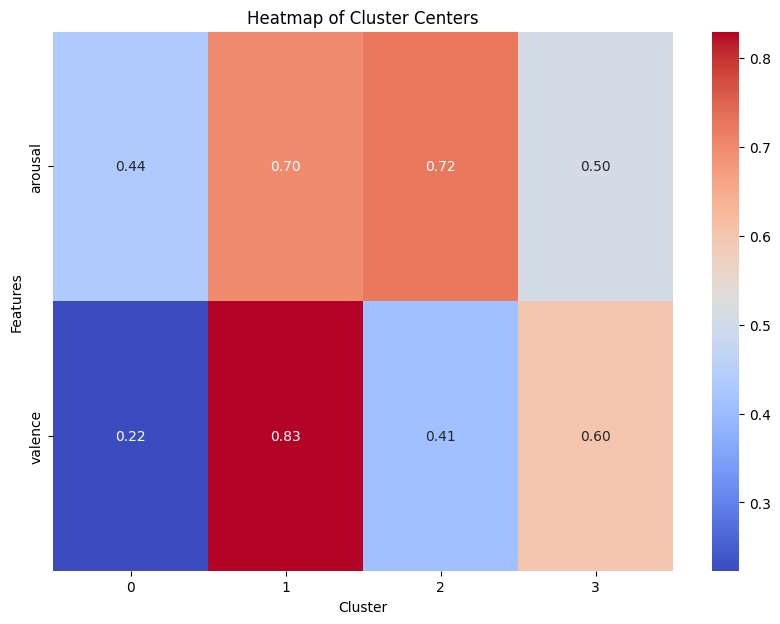

In [12]:
# Load the data
data_scaled_labeled = joblib.load(data_scaled_labeled_pkl)

# Plotting the heatmap of the clusters first (based on mood)
plt.figure(figsize=(10, 7))

# Group by the 'mood' column and calculate the mean for each cluster (feature-wise)
# Transpose the result for better visualization (features as rows, clusters as columns)
sns.heatmap(data_scaled_labeled.groupby('mood').mean().T, annot=True, cmap='coolwarm', fmt=".2f")

# Adding labels and title
plt.title('Heatmap of Cluster Centers')
plt.ylabel('Features')
plt.xlabel('Cluster')

# Show the plot
plt.show()

### From the Circumplex model of emotion developed by James Russel

![image.png](./Images/circumplex_model_of_emotion.svg)

#### Nosotros elegimso los siguientes labels

- Cluster 0 (low arousal, low valence): Sadness/Depression
- Cluster 1 (high arousal, high valence): Joy/Excitement
- Cluster 2 (high arousal, low valence): Anger/Tense
- Cluster 3 (low arousal, high valence): Calmness/Relaxation


In [13]:
#Mapping Cluster number with a Labeled mood
cluster_to_mood = {
    0: 'Sadness/Depression',
    1: 'Joy/Excitement',
    2: 'Anger/Tense',
    3: 'Calmness/Relaxation'
}

### Con modelo final y el label del mood y cargamos un dataset mas pequeno pero mas actulizado para recomendar canciones

In [31]:
def predict_moods_from_file(input_data_csv: str, input_model_pkl: str, 
                            output_original_predict_pkl: str, output_scaled_predict_pkl: str,
                            label_map: dict):

    start_time = time.time()

    print(f"Predict new dataset mood")

    # Load model
    model = joblib.load(input_model_pkl)

    # Load original data (before scaling) for later use
    df = pd.read_csv(input_data_csv)

    # File paths for the pickle files
    pkl_file1 = 'datascaled.pkl'
    pkl_file2 = 'datascaled_aux.pkl'
    
    # Clean and normalize the dataset (add scaled original features to understand?)
    clean_normalize_dataset(input_data_csv, pkl_file1, pkl_file2)
    data_scaled = joblib.load(pkl_file1)

    # Predict moods
    moods = model.predict(data_scaled)

    # Add mood column
    df['mood'] = moods
    df['mood'] = df['mood'].map(label_map)
    df['arousal'] = data_scaled['arousal']

    data_scaled_save = joblib.load(pkl_file2)
    data_scaled_save['mood'] = moods
    data_scaled_save['track_id'] = df['track_id']

    new_column_order = ['track_id','mood','valence','arousal', 'energy', 'tempo', 'loudness', 'danceability']
    data_scaled_save = data_scaled_save[new_column_order]

    df = df[['artists', 'track_name', 'track_id', 'mood', 'valence', 'arousal', 'energy', 'tempo', 'loudness', 'danceability', 'duration_ms', 'popularity', 'track_genre']]

    # Save results
    joblib.dump(df, output_original_predict_pkl)
    joblib.dump(data_scaled_save, output_scaled_predict_pkl)

    # Logging
    print(f"\n\nMood predictions saved to: {output_original_predict_pkl}")
    print(f"Scaled data with predictions saved to: {output_scaled_predict_pkl}")

    # Delete the pickle files
    os.remove(pkl_file1)
    os.remove(pkl_file2)

    print(f"Predict new dataset mood Completed in {time.time() - start_time:.2f} seconds")

# Predict new database with the best model
predict_moods_from_file(src_spotify_new_dataset,
                        best_model,
                        data_new_scaled_pkl,
                        data_new_scaled_labeled_pkl,
                        cluster_to_mood)

df = joblib.load(data_new_scaled_pkl)
df.to_csv(f"./Data/dataset_new_labeled.csv", index=False)
print(f"\nOriginal file with selected features\n{df.head()}")

df = joblib.load(data_new_scaled_labeled_pkl)
df.to_csv(f"./Data/dataset_new_scaled_labeled.csv", index=False)
print(f"\nScaled file with selected features\n{df.head()}")


Predict new dataset mood
Clean and Normalize Dataset
Shape Original: (114000, 21)
Missing data before cleanup: 0 entries.
Original Data Description:
              energy          tempo       loudness   danceability  \
count  114000.000000  114000.000000  114000.000000  114000.000000   
mean        0.641383     122.147837      -8.258960       0.566800   
std         0.251529      29.978197       5.029337       0.173542   
min         0.000000       0.000000     -49.531000       0.000000   
25%         0.472000      99.218750     -10.013000       0.456000   
50%         0.685000     122.017000      -7.004000       0.580000   
75%         0.854000     140.071000      -5.003000       0.695000   
max         1.000000     243.372000       4.532000       0.985000   

             valence  
count  114000.000000  
mean        0.474068  
std         0.259261  
min         0.000000  
25%         0.260000  
50%         0.464000  
75%         0.683000  
max         0.995000  
First few rows of the 

> **_NOTE:_** Tomar algunos datos de las predicciones hechas en el nuevo data set y ver si corresponden al mood (hacer tambien al inicio con la eleccion de clusters??)